# Introduction

Goal of this project is to analyze the number of building permit applications submitted for approval regarding construction of new housing units within the state of Massachusetts.

The intent is to scope, prepare, plot data, seek out any differences \ trends apparent from the analysis, and determine any statistical significance via hypothesis testing.

### Analysis Goals

- Have certain areas boomed prior to the pandemic and then never returned?

- How has the pandemic affected the number of residential building permit applications the state of Massachusetts has seen? Does population / town (or city) size play a role in this?

### Data sources:

The data was obtained from the U.S. Census Bureau webpage: https://www2.census.gov/econ/bps/Place/

Data (in csv format) was downloaded from the northeastern region of the United States between the years 2010 - 2021. Each seperate csv file represent survey data collected by the census bureau for each month.

### Python Module Import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import os, glob
from scipy.stats import chi2_contingency
import plotly.express as px
import geopandas as gdp
from __future__ import print_function
import ipywidgets as widgets
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Table of Contents

1. Initial Data Frame Set Up & Inspection
2. Exploratory Data Analysis
3. Geopandas Visualizations
3. Data Frame Transformation & Visualizations
4. Hypothesis Testing

# 1. Initial Data Inspection

In [3]:
sample = pd.read_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_data\monthly_data\ne2001c.txt')
pd.set_option('display.max_columns', None)
sample.head()

Survey   State 6-Digit County Census Place FIPS Place FIPS MCD   Pop  \
Date     Code      ID    Code   Code         Code       Code           Code   
202001     09  001000     013              00000      01080     3303    278   
202001     09  013000     003              00000      02060    18098    278   
202001     09  029000     003              00000      04300    19866    278   
202001     09  037000     001              00000      04720    18584    408   

          CSA  CBSA Footnote      Central   Zip Region Division        Source  \
Date     Code  Code     City         Code  Code   Code     Code          Name   
202001  25540                 06232           1      1        3  Andover town   
202001  25540                 06001           1      1        1     Avon town   
202001  25540                 06037           1      1        3   Berlin town   
202001  14860                 06801           1      1        5   Bethel town   

        Place Unnamed: 17   1-unit Unnamed: 19 Unnamed: 20 2-units  \
Date    Bldgs       Units    Value       Bldgs       Units   Value   
202001      0           0        0           0           0       0   
202001      0           0        0           0           0       0   
202001      0           0        0           0           0       0   
202001      4           4  1224766           0           0       0   

       Unnamed: 22 Unnamed: 23 3-4 units Unnamed: 25 Unnamed: 26 5+ units  
Date         Bldgs       Units     Value       Bldgs       Units    Value  
202001           0           0         0           0           0        0  
202001           0           0         0           0           0        0  
202001           0           0         0           0           0        0  
202001           0           0         0           0           0        0

We see that due to heading format in txt file, part of the column name imports as a row of data. We will need to combine all files into data frame, rename columns and delete rows with the column info in it.

### Combining all txt files into data frame

In [4]:
#Define folder pather containing txt data files
files_folder = r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_data\monthly_data'
files = []

In [5]:
#Create dataframe list using list comprehension for all csv files in project folder
#Skipinitialspace command removes all the unnecessary blank white spaces within each cell
files = [pd.read_csv(file, delimiter = ',', skipinitialspace = True)\
         for file in glob.glob(os.path.join(files_folder, '*.txt'))]

In [6]:
#Creating column names in correct order
column_names = ['date','State','6-Digit','County','Census Place','FIPS Place', \
                'FIPS MCD','Pop','CSA','CBSA','Footnote','Central','Zip','Region', \
                'Division','Source','Place','1-unit_bldgs','1-unit_units','1-unit_value',\
                '2-units_bldgs','2-unit_units','2-unit_value',\
                '3-4-units_bldgs','3-4-unit_units','3-4-unit_value',\
                '5_plus-units_bldgs','5_plus-units_units','5_plus-units_value']

In [7]:
raw_files_df = pd.concat(files).reset_index()

In [8]:
#renaming column names to correct order
raw_files_df.columns = column_names

#removing first row of data that contains column name info
files_df = raw_files_df[raw_files_df.date != 'Date']

#converting date column to datetime data type
files_df['date'] = pd.to_datetime(files_df.loc[:,'date'], format = '%Y%m')

#removing unnecessary columns
files_df.drop(['Census Place', 'Footnote', 'Central','Region', 'Division', 'Source' ], axis = 1 , inplace = True)

## Classifying each Place based on population size
(https://www2.census.gov/geo/pdfs/reference/GARM/Ch12GARM.pdf)

**Urbanized Areas (UAs)**
A UA is a continuously built-up area with a population of 50,000 or more.
It comprises one or more places—central place(s)—and the adjacent
densely settled surrounding area—urban fringe—consisting of other
places and nonplace territory.

**Urban Places Outside of UAs (UP)**
Outside of UAs, an urban place is any incorporated place or census designated place (CDP) with at least 2,500 inhabitants. A CDP is a densely
settled population center that has a name and community identity, and
is not part of any incorporated place (see Chapter 9, “Places”).

**Rural Places and Territory (R)**
Territory, population, and housing units that the Census Bureau does
not classify as urban are classified as rural. For instance, a rural place is
any incorporated place or CDP with fewer than 2,500 inhabitants that is
located outside of a UA. A place is either entirely urban or entirely rural,
except for those designated as an extended city.


In [9]:
files_df['classif'] = files_df['Pop'].apply(lambda val: 'Urban_Area' if val >= 50000\
                                         else ('Urban_Place' if (val >= 2500 and val < 50000)
                                         else 'Rural'))

In [10]:
files_df.head()

date State 6-Digit County FIPS Place FIPS MCD      Pop  CSA   CBSA  \
1 2010-01-01    09  001000    013        NaN   01080    3036.0  278  25540   
2 2010-01-01    09  005000    009     01150    01220   18554.0  408  35300   
3 2010-01-01    09  009000    015        NaN   01430    4098.0  999  99999   
4 2010-01-01    09  013000    003        NaN   02060   15832.0  278  25540   
5 2010-01-01    09  029000    003        NaN   04300   18215.0  278  25540   

           Zip         Place 1-unit_bldgs 1-unit_units 1-unit_value  \
1  06232        Andover town            0            0            0   
2  064011855         Ansonia            0            0            0   
3  06278        Ashford town            0            0            0   
4  06001           Avon town            2            2       783740   
5  06037         Berlin town            3            3       411954   

  2-units_bldgs 2-unit_units 2-unit_value 3-4-units_bldgs 3-4-unit_units  \
1             0            0            0               0              0   
2             0            0            0               0              0   
3             0            0            0               0              0   
4             0            0            0               0              0   
5             0            0            0               0              0   

  3-4-unit_value 5_plus-units_bldgs 5_plus-units_units 5_plus-units_value  \
1              0                  0                  0                  0   
2              0                  0                  0                  0   
3              0                  0                  0                  0   
4              0                  0                  0                  0   
5              0                  0                  0                  0   

       classif  
1  Urban_Place  
2  Urban_Place  
3  Urban_Place  
4  Urban_Place  
5  Urban_Place

In [11]:
#changing all appropriate values to float values. "Errors = Ignore" insures all values that are suppose to be objects
#(e.g. city names) are still object data types.

for column in files_df.columns:
    files_df[column] = files_df[column].astype(int, errors = 'ignore')

In [12]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382712 entries, 1 to 382858
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                382712 non-null  datetime64[ns]
 1   State               382712 non-null  int32         
 2   6-Digit             382712 non-null  int32         
 3   County              382712 non-null  int32         
 4   FIPS Place          293701 non-null  object        
 5   FIPS MCD            382065 non-null  object        
 6   Pop                 382098 non-null  float64       
 7   CSA                 382712 non-null  int32         
 8   CBSA                382712 non-null  int32         
 9   Zip                 382712 non-null  object        
 10  Place               382712 non-null  object        
 11  1-unit_bldgs        382712 non-null  int32         
 12  1-unit_units        382712 non-null  int32         
 13  1-unit_value        382712 no

In [13]:
#Convert Survey Column to a data-time data type
files_df['year'] = pd.DatetimeIndex(files_df['date']).year
files_df['month'] = pd.DatetimeIndex(files_df['date']).month

In [14]:
files_df.head()

date  State  6-Digit  County FIPS Place FIPS MCD      Pop  CSA   CBSA  \
1 2010-01-01      9     1000      13        NaN   01080    3036.0  278  25540   
2 2010-01-01      9     5000       9     01150    01220   18554.0  408  35300   
3 2010-01-01      9     9000      15        NaN   01430    4098.0  999  99999   
4 2010-01-01      9    13000       3        NaN   02060   15832.0  278  25540   
5 2010-01-01      9    29000       3        NaN   04300   18215.0  278  25540   

           Zip         Place  1-unit_bldgs  1-unit_units  1-unit_value  \
1  06232        Andover town             0             0             0   
2  064011855         Ansonia             0             0             0   
3  06278        Ashford town             0             0             0   
4  06001           Avon town             2             2        783740   
5  06037         Berlin town             3             3        411954   

   2-units_bldgs  2-unit_units  2-unit_value  3-4-units_bldgs  3-4-unit_units  \
1              0             0             0                0               0   
2              0             0             0                0               0   
3              0             0             0                0               0   
4              0             0             0                0               0   
5              0             0             0                0               0   

   3-4-unit_value  5_plus-units_bldgs  5_plus-units_units  5_plus-units_value  \
1               0                   0                   0                   0   
2               0                   0                   0                   0   
3               0                   0                   0                   0   
4               0                   0                   0                   0   
5               0                   0                   0                   0   

       classif  year  month  
1  Urban_Place  2010      1  
2  Urban_Place  2010      1  
3  Urban_Place  2010      1  
4  Urban_Place  2010      1  
5  Urban_Place  2010      1

### According to census bureau, the state code for MA = 25. Select data only assigned to this code

In [15]:
ma_df = files_df.query('State == 25').reset_index(drop = True)

In [16]:
#Creating additional column which sums the total amount of buildings independent on the number of units a building contains
ma_df['total_buildings'] = ma_df['1-unit_bldgs'] + ma_df['2-units_bldgs']+ ma_df['3-4-units_bldgs'] \
                        + ma_df['5_plus-units_bldgs']

#Creating extra column adding up number of 2,3,4 unit buildings. This will help us in our analysis later on when we break 
#out our analysis in terms of single family homes, small condos, and large condos
ma_df['total_small_bldgs'] = ma_df['2-units_bldgs']+ ma_df['3-4-units_bldgs']

In [17]:
#Creating additional column which sums the total amount of units independent on the number of units a building contains
ma_df['total_units'] = ma_df['1-unit_units'] + ma_df['2-unit_units']+ ma_df['3-4-unit_units'] \
                        + ma_df['5_plus-units_units']

#Creating extra column adding up number of 2,3,4 unit buildings. This will help us in our analysis later on when we break 
#out our analysis in terms of single family homes, small condos, and large condos
ma_df['total_small_units'] = ma_df['2-unit_units']+ ma_df['3-4-unit_units']

In [18]:
#Loading in county key to identify county name by number listed in main data frame
county_key_df = pd.read_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_data\st25_ma_cou_csv.csv')

In [19]:
#adding new column so we can identify what county each place is associated with
ma_df = ma_df.merge(county_key_df, how = 'left', on = 'County')

In [20]:
#stripping suffix 'town' from any location name
ma_df['Place'] = ma_df.Place.str.split(' town', regex = True, ).str.get(0)

In [21]:
ma_df.Place

0           Abington
1              Acton
2             Agawam
3           Amesbury
4            Andover
            ...     
30938         Woburn
30939      Worcester
30940    Worthington
30941       Wrentham
30942       Yarmouth
Name: Place, Length: 30943, dtype: object

In [22]:
ma_df.to_csv(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\csv_results\ma_df.csv',index=False,header = True)

# 2. Exploratory Data Analysis

In [23]:
#obtaining unique years in data set
years = ma_df.year.unique()
years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022], dtype=int64)

In [24]:
#obtaining a count of how many urban places, urban areas and rural places there are in the data set
ma_df.query('year == 2021 and month ==1')['classif'].value_counts()

Urban_Place    159
Urban_Area      22
Rural            8
Name: classif, dtype: int64

In [25]:
#Determining the shape of the population within the MA data set
ma_df.query('year == 2021 and month ==1')['Pop'].describe()

count       189.000000
mean      25845.153439
std       48353.223448
min          75.000000
25%        8183.000000
50%       15873.000000
75%       28602.000000
max      617594.000000
Name: Pop, dtype: float64

### View distribution of total building permits per month

In [26]:
ma_df_piv = pd.pivot_table(ma_df, 
                           index = ['date','year', 'month'], 
                           values = ['total_buildings'], aggfunc = np.sum).reset_index()

In [27]:
ma_df_piv_class = pd.pivot_table(ma_df, 
                           index = ['date','year', 'month', 'classif'], 
                           values = ['total_buildings'], aggfunc = np.sum).reset_index()

In [28]:
ma_df_piv.head()

date  year  month  total_buildings
0 2010-01-01  2010      1              301
1 2010-02-01  2010      2              307
2 2010-03-01  2010      3              393
3 2010-04-01  2010      4              459
4 2010-05-01  2010      5              424

### View distribution of total building permits per year

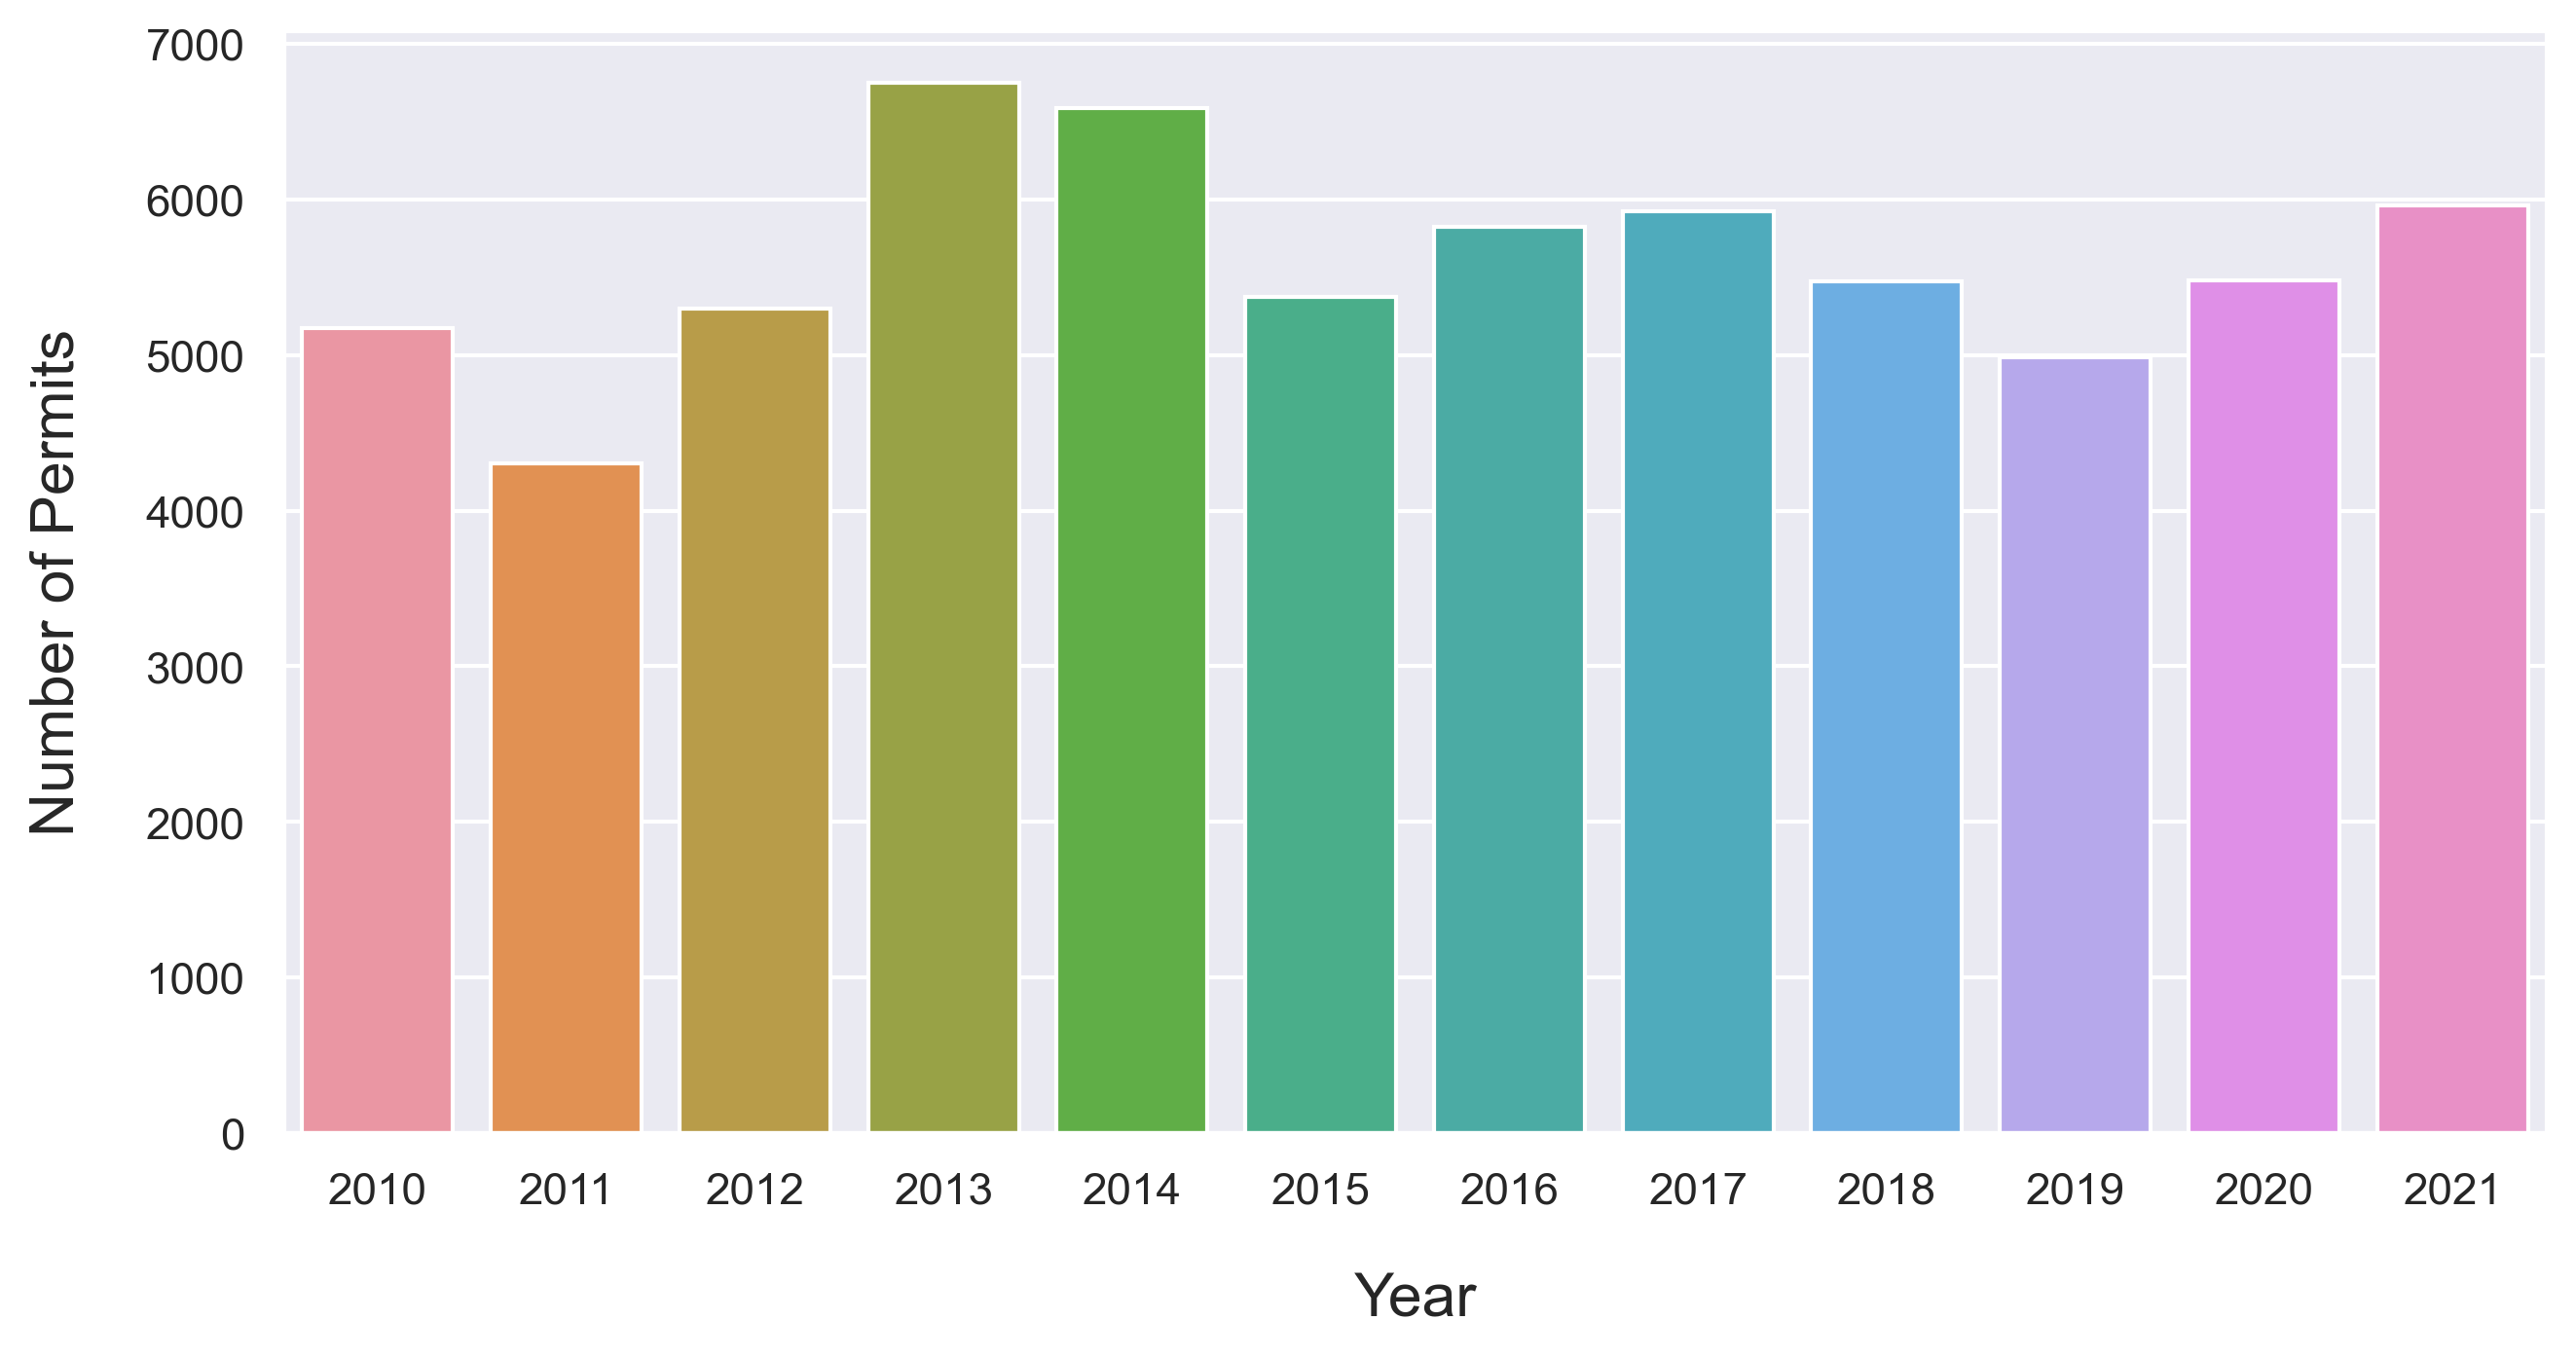

In [29]:
yearly_permits = ma_df_piv.query('year != 2022').groupby('year')['total_buildings'].sum().reset_index()

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

plt.figure(figsize = (10,5))
bar = sns.barplot(x = 'year',
           y = 'total_buildings',
           data = yearly_permits,
           )

bar.set_xlabel('Year', fontsize = 15, labelpad = 15)
bar.set_ylabel('Number of Permits', fontsize = 15, labelpad = 15)
#bar.set_title('Annual Total Authorized Building Permits', fontsize = 20)
plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\bar.png', dpi=300,
           bbox_inches='tight')

### COVID-19 Important Mile Stone: MA State of Emergency

On March 10, 2020, Gov. Charlie Baker declared a state of emergency as cases of COIVD-19 began to spike in Massachusetts. This is the approx. start when COVID restrictions began. We will use this date as a marker in the analysis to determine how the application submission rate has been affected.

Source: https://www.nbcboston.com/life-in-lockdown/life-in-lockdown-a-timeline-of-the-covid-shutdown-in-massachusetts/2320541/

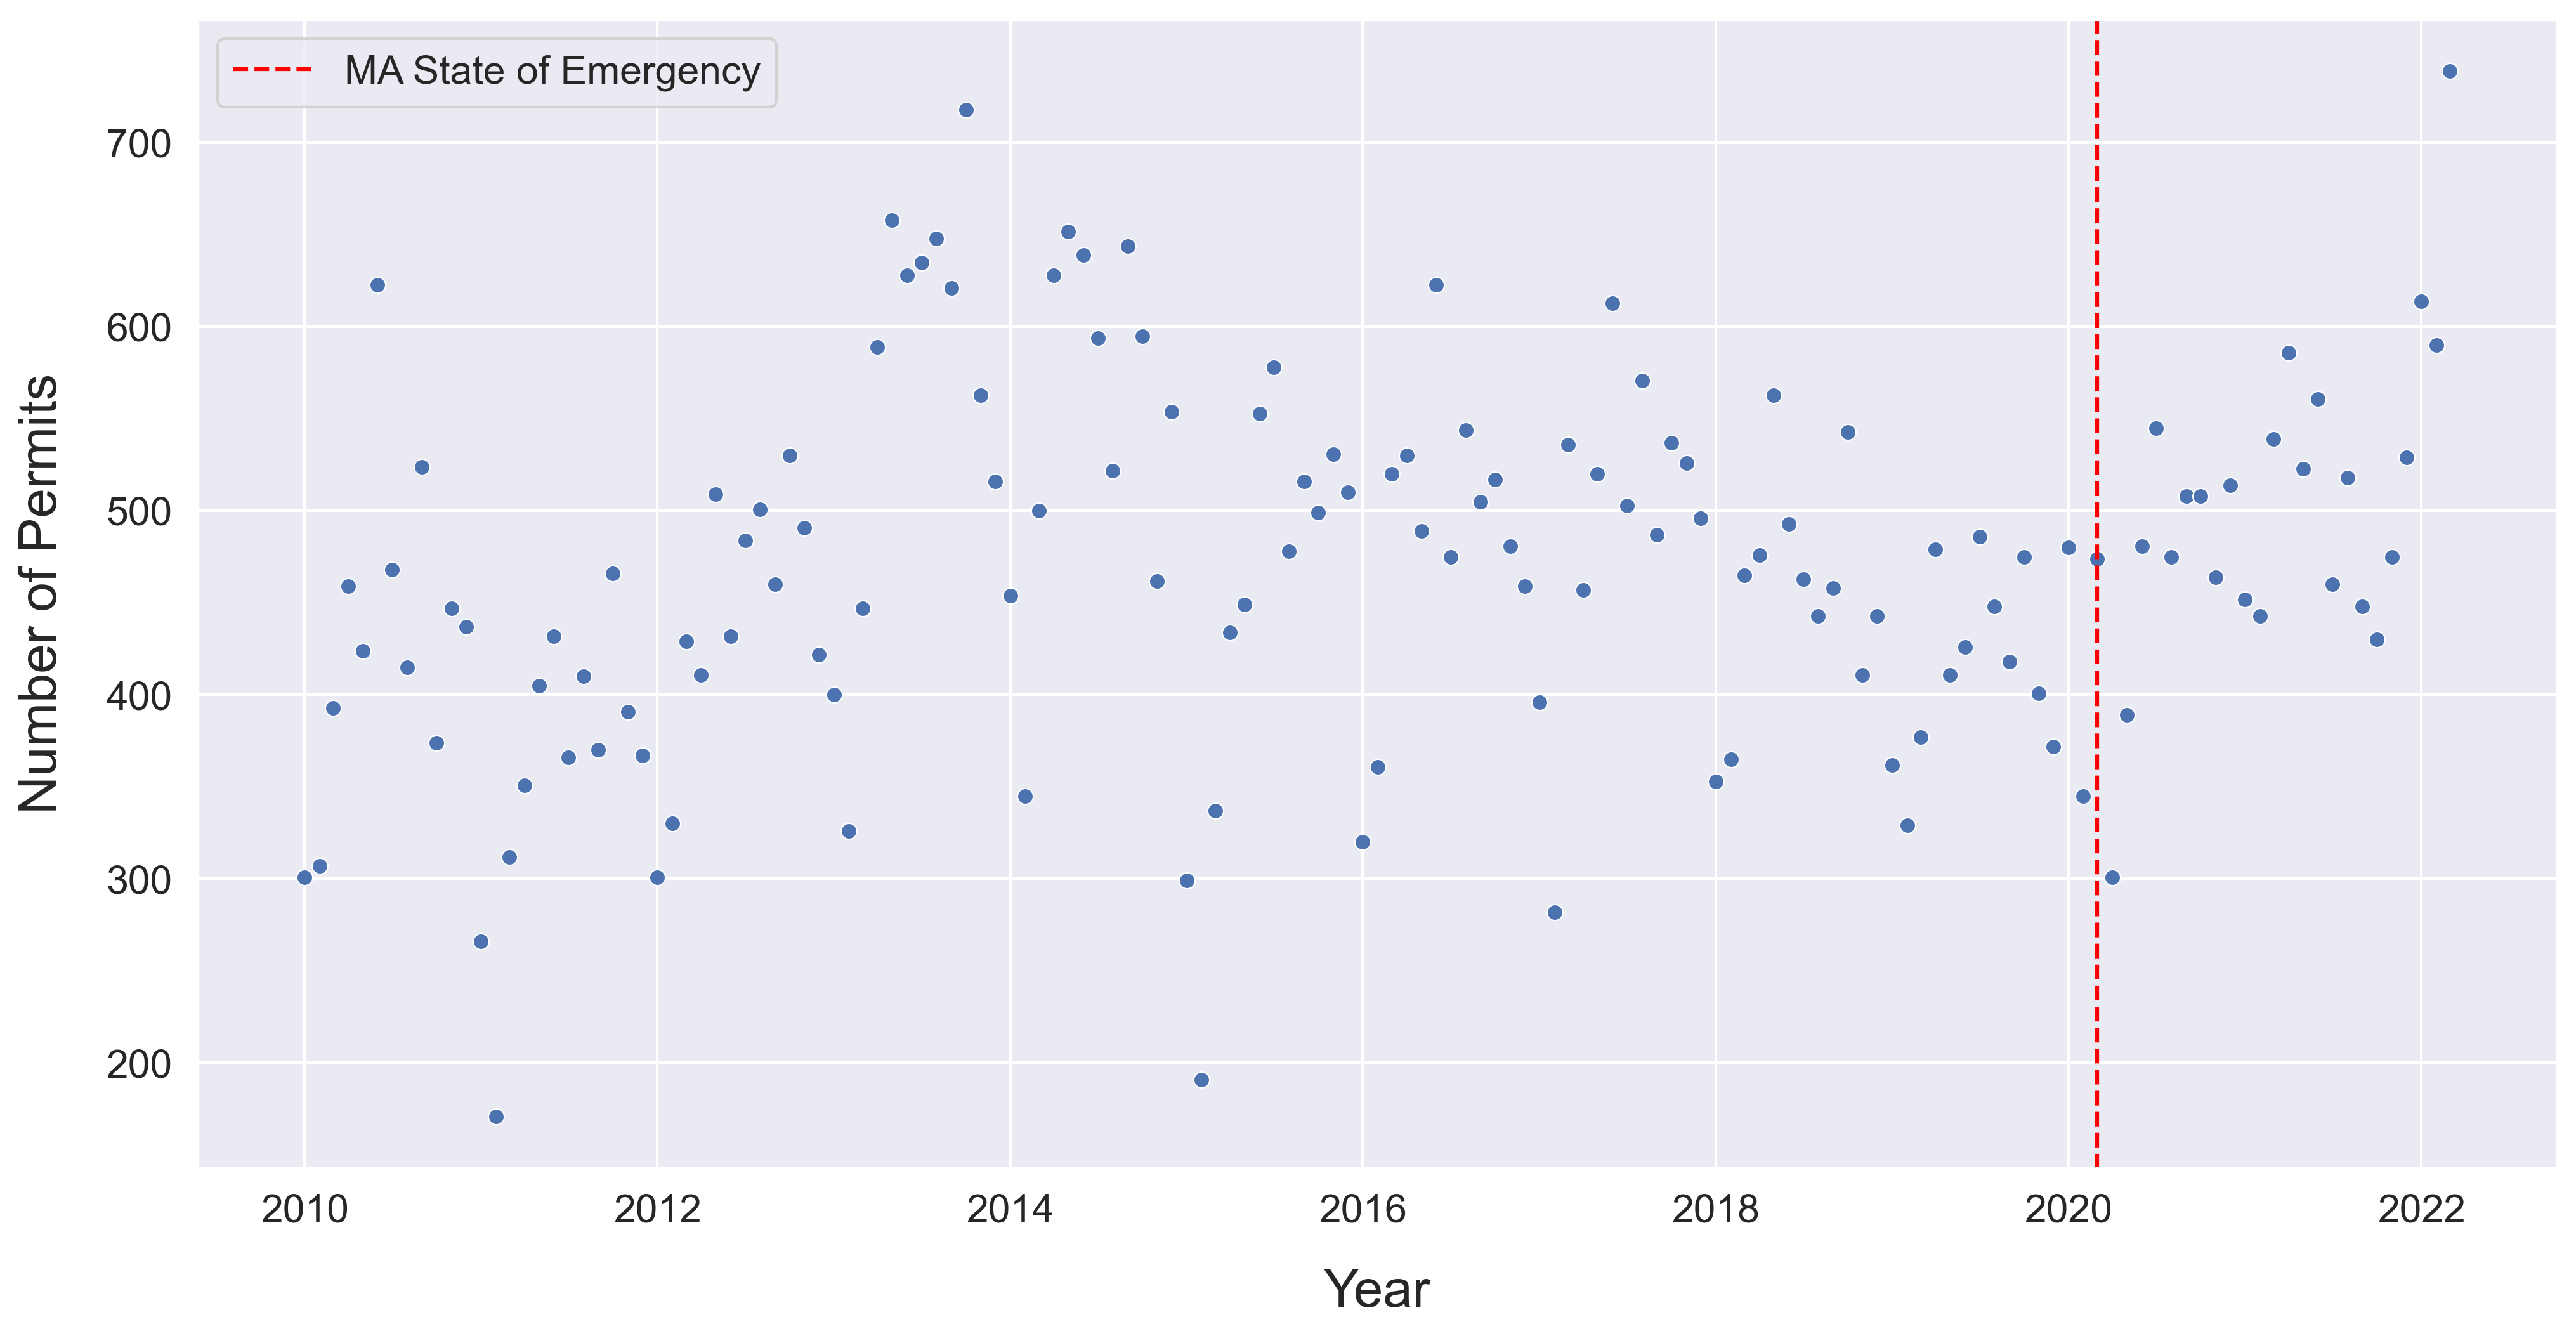

In [30]:
sns.set(style = 'darkgrid')
plt.figure(figsize = (16,8))

scatter = sns.scatterplot(
    x = ma_df_piv.date, y = ma_df_piv.total_buildings)

#red vertical line indicates start date of COVID-19 restrictions
plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--', label = 'MA State of Emergency' )
plt.legend(fontsize = 15)

scatter.set_xlabel('Year', fontsize = 20, labelpad = 15)
scatter.set_ylabel('Number of Permits', fontsize = 20, labelpad = 15)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15)
#scatter.set_title('Montly Total Authorized Building Permits', fontsize = 20)


plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\scatter1.png', dpi=300,
           bbox_inches='tight')

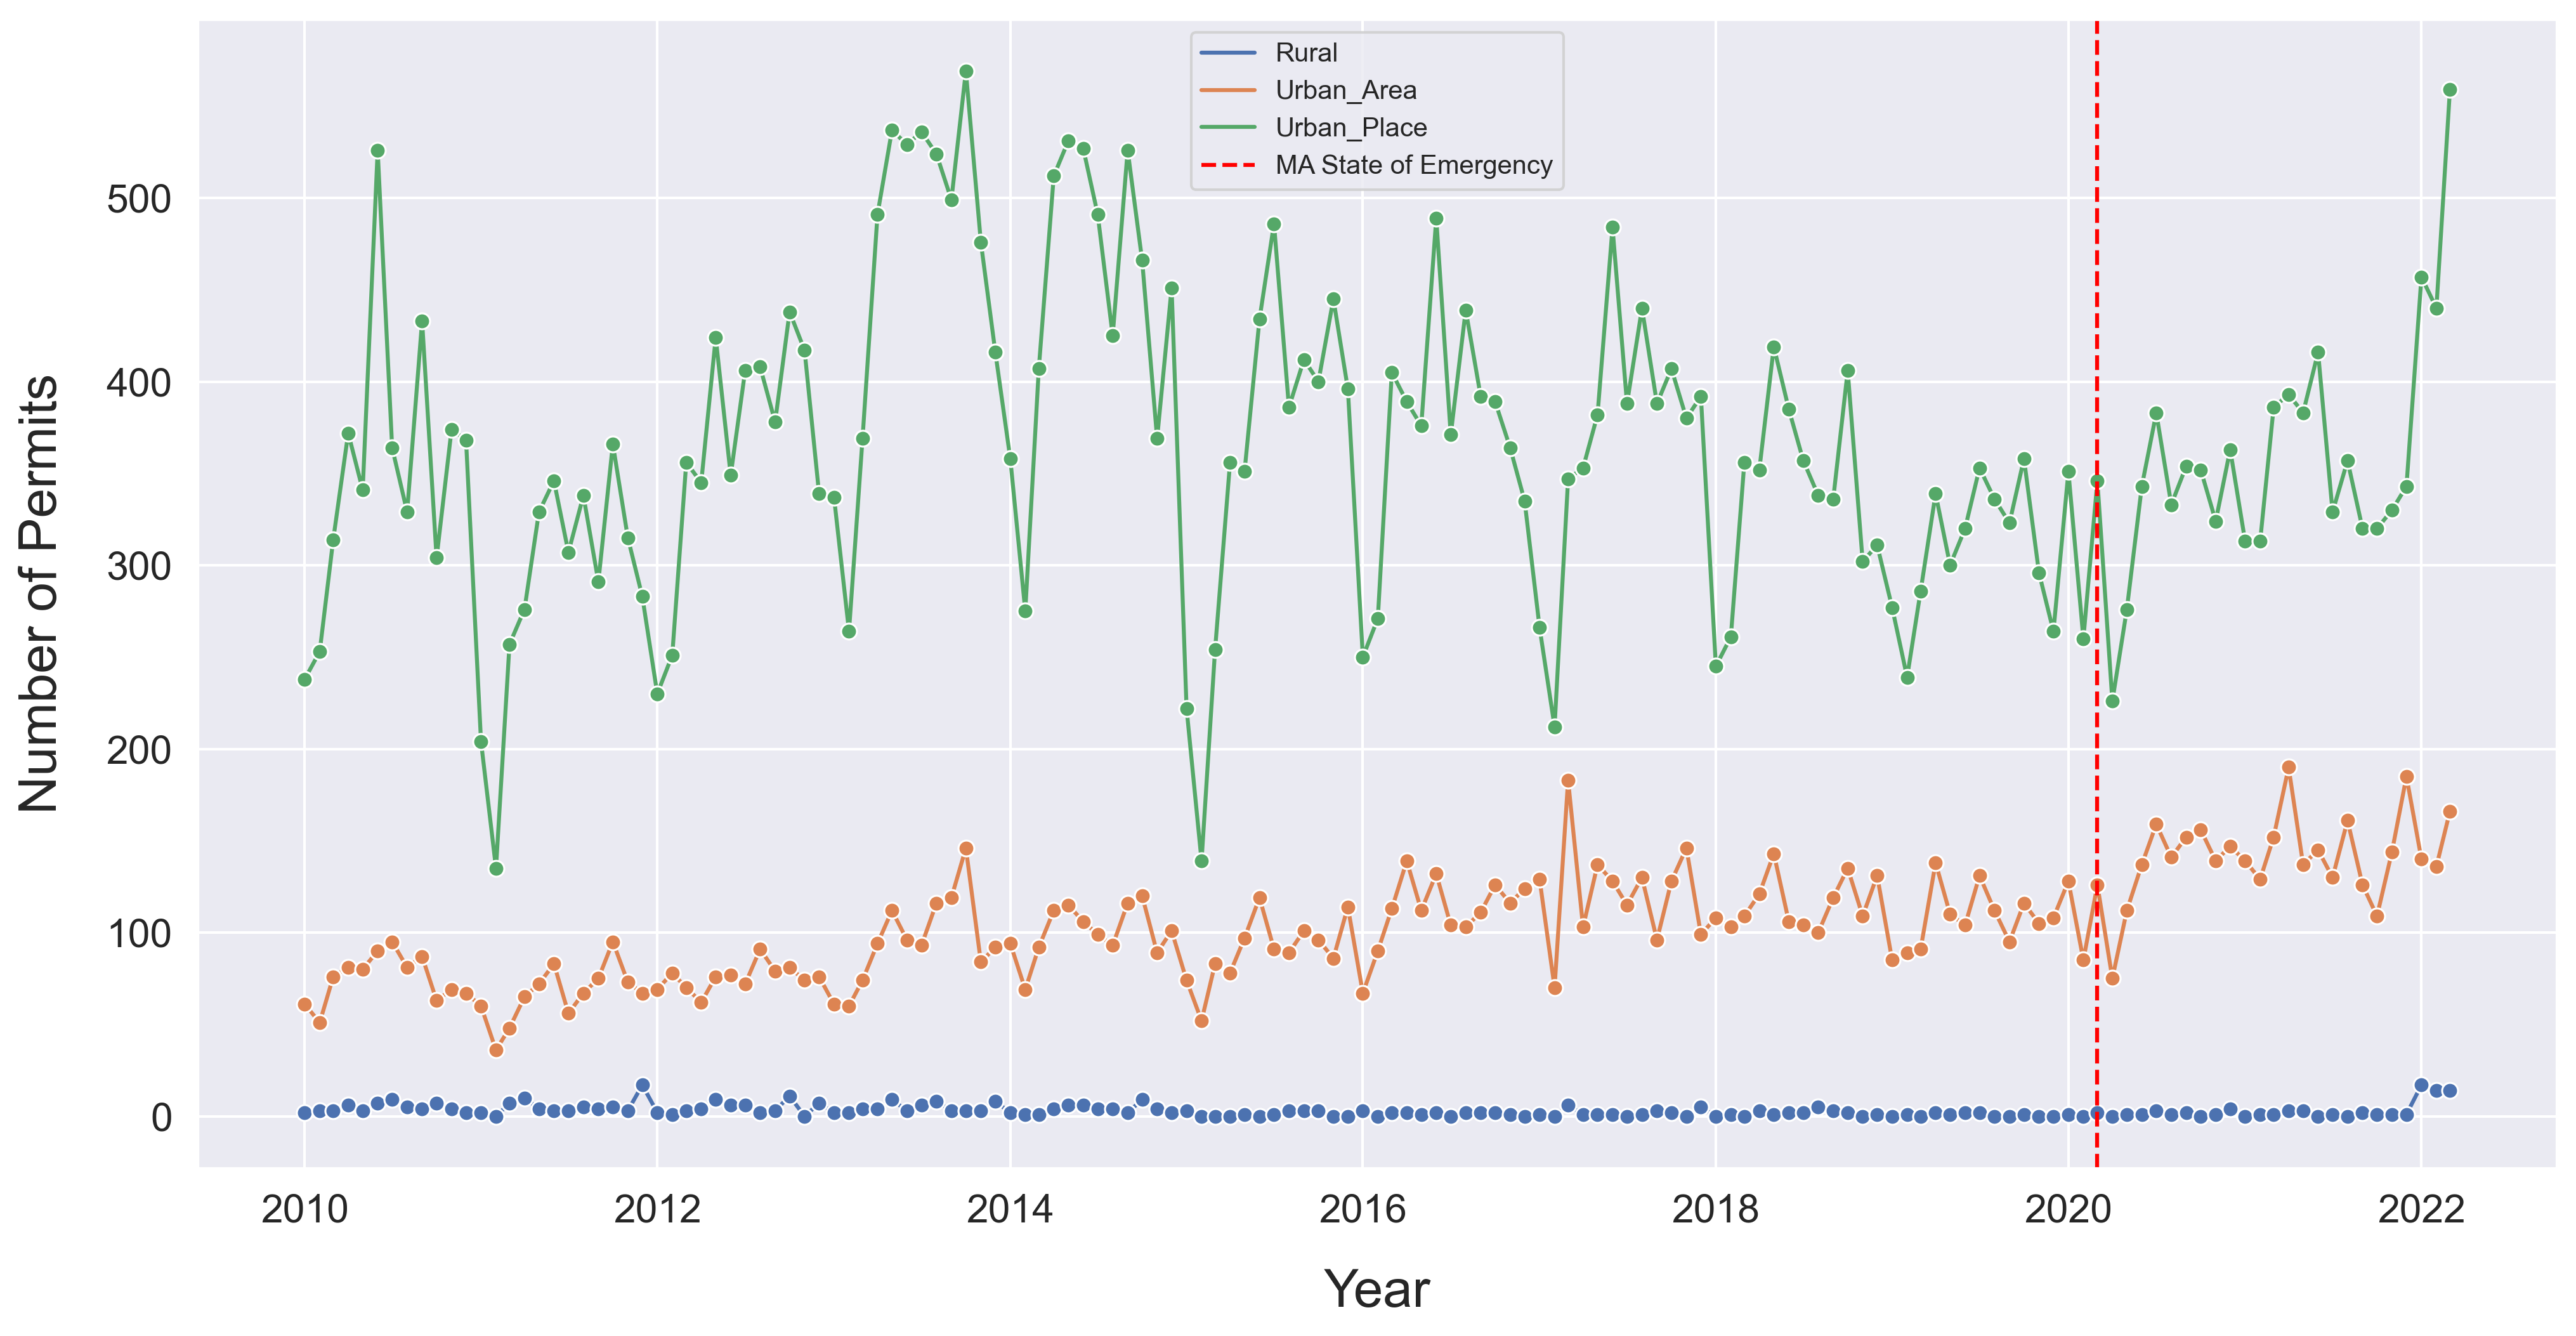

In [31]:
sns.set(style = 'darkgrid')
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.figure(figsize = (16,8))

line = sns.lineplot(
    x = ma_df_piv_class.date, y = ma_df_piv_class.total_buildings, hue = ma_df_piv_class.classif,
    marker = 'o',
    )

#red vertical line indicates start date of COVID-19 restrictions
plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--', label = 'MA State of Emergency' )
plt.legend(fontsize = 10)

line.set_xlabel('Year', fontsize = 20, labelpad = 15)
line.set_ylabel('Number of Permits', fontsize = 20, labelpad = 15)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15)
#line.set_title('Montly Total Authorized Building Permits Per Population Classification', fontsize = 20)

plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\scatter2.png', dpi=300,
           bbox_inches='tight')

### Initial Observations

It appears that number of applications is dependent on population size. From plotting the initial data set as a scatter plot, we can observe the data tends to cluster in three groups. Based on this information, the data was grouped by place size (Urban Area, Urban Place, Rural) then plotted, confirming our initial observation.

# 3. Geopandas Visualizations

In [32]:
#obtaining unique years in data set
years = ma_df.year.unique()
years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022], dtype=int64)

In [33]:
#create new dictionary, relating unique years to their own data frame (that is empty)
yeardict = {year:pd.DataFrame() for year in years}

#assigning subset of main dataframe (based on specified year) to empty dataframes created in the new dictionary above
for key in yeardict.keys():
    yeardict[key] = ma_df[:][ma_df.year == key]

In [34]:
mapdf = gdp.read_file(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\shape files\TOWNSSURVEY_POLYM.shp')

## Geopandas plot (2021)

Create static heat map showing authorized building permit total counts for the year 2021

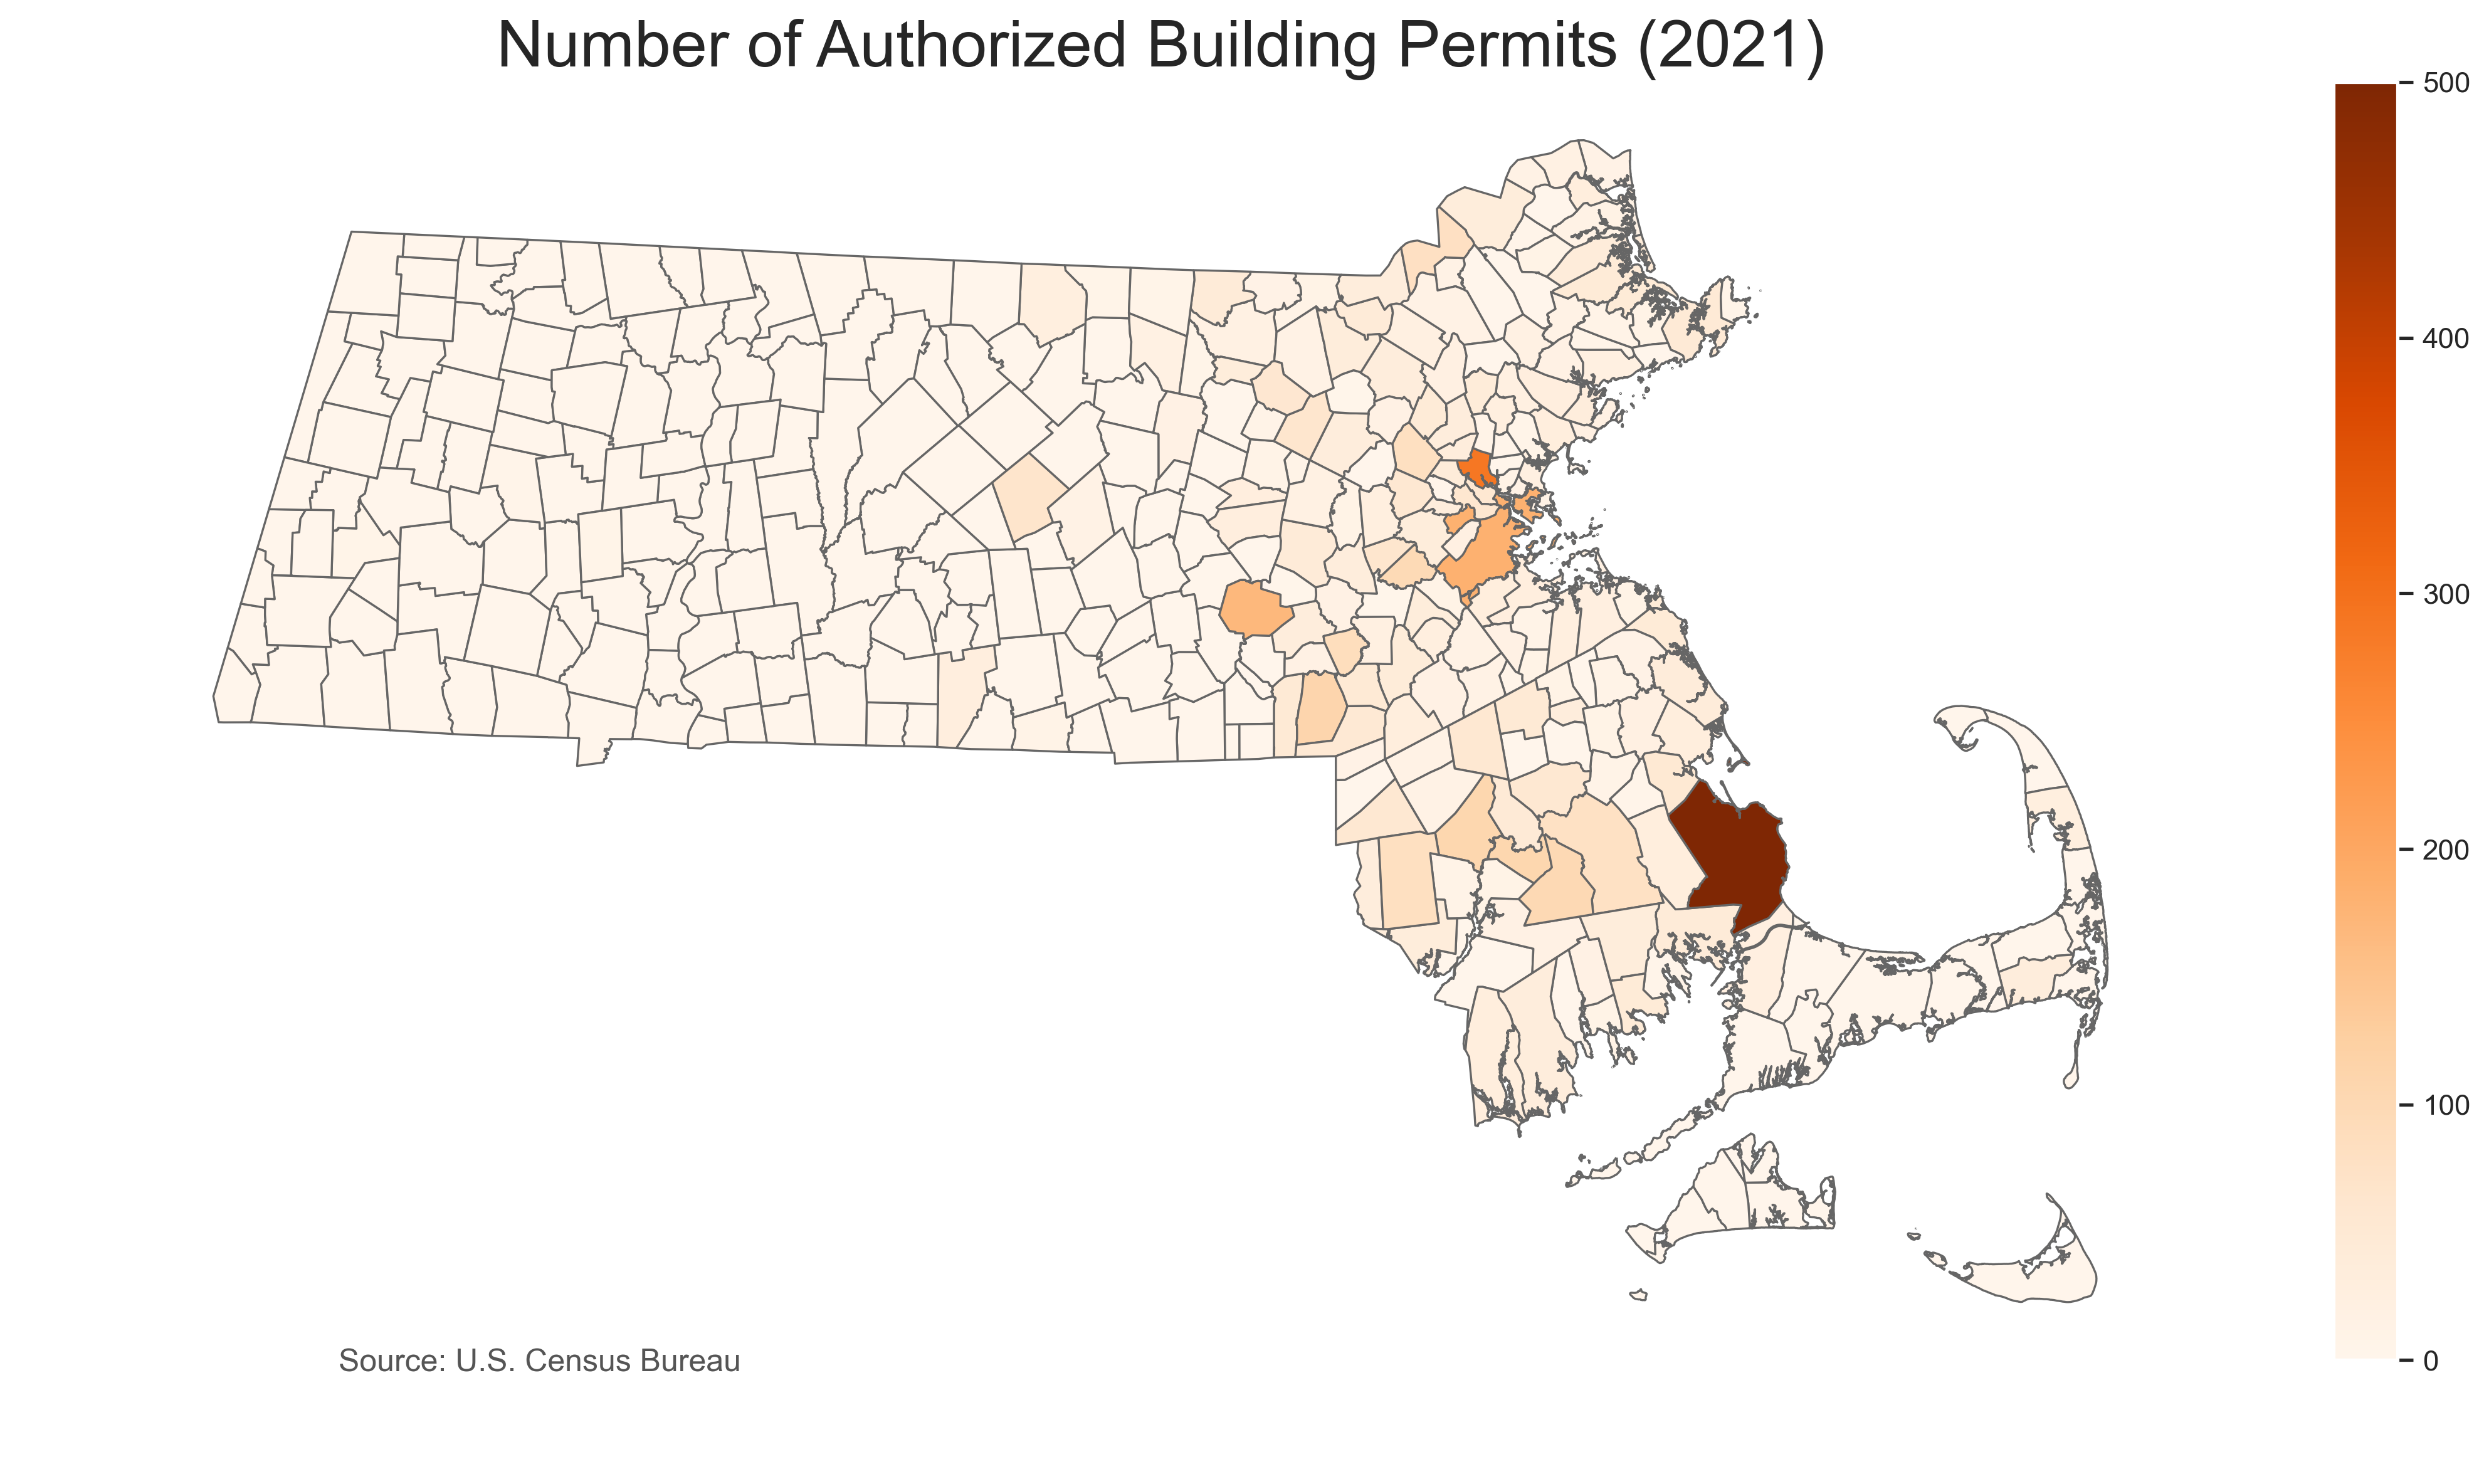

In [35]:
#setting up new dataframe that contains spacial data, permit counts for the year 2021
geo_df2021 = yeardict[2021].groupby(['year','Place'])['total_buildings'].sum().reset_index()
geo_df2021['str_split'] = geo_df2021.Place.str.split(' ')
geo_df2021['TOWN'] = geo_df2021.str_split.str[0].str.upper()
geo_df2021 = geo_df2021.drop(['Place', 'str_split'], 1)
merge2021 = mapdf.merge(geo_df2021, how = 'left', on = 'TOWN').fillna(0)

#Creating local ax to plot
fig, ax = plt.subplots(1, figsize = (18,9))
#Source annotation
ax.annotate('Source: U.S. Census Bureau',
        xy=(0.1, .08), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=12, color='#555555')
#Setting title of figure
ax.set_title('Number of Authorized Building Permits (2021)', \
            fontdict={'fontsize': '25',
                    'fontweight' : '3'})
ax.axis('off')
#Plotting figure
merge2021.plot(column='total_buildings',figsize=(20,9),cmap='Oranges',
                                            linewidth=0.8, edgecolor='0.4', legend = True, axes = ax, vmax = 500)

plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\heatmap.png', dpi=300,
           bbox_inches='tight')

## Interactive Geopandas plot (2021)

Creating interactive map showing authorized building permit total counts for the year 2021. Figure will show city names and display count values when hovering mouse over areas.

In [68]:
map = merge2021.explore(
    column = 'total_buildings',
    tooltip = "total_buildings",
    cmap ='Oranges',
    style_kwds = dict(color = "grey"),
    vmax = 300)

map.save(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\map_results\map.html')

## Interactive Geopandas plot (Multi-Year)

Creating interactive map showing authorized building permit total counts for the every year available in data set. Note this figure will not show up unless ipykernel is active.

In [37]:
#creating a list of distinct years within the data set
target_years = ([i for i in pd.DatetimeIndex(ma_df.date).year.unique()])
target_merge = pd.DataFrame()

#setting up new dataframe that contains spacial data, permit counts, and the respective year
for i in target_years:
    temp_df = yeardict[i].groupby(['year','Place'])['total_buildings'].sum().reset_index()
    temp_df['str_split'] = temp_df.Place.str.split(' ')
    temp_df['TOWN'] = temp_df.str_split.str[0].str.upper()
    temp_df = temp_df.drop(['Place', 'str_split'], 1)
    mergetemp = mapdf.merge(temp_df, how = 'left', on = 'TOWN')
    mergetemp = mergetemp.fillna({'year':i,'total_buildings':0})
    target_merge = target_merge.append(mergetemp)

In [38]:
def worldplot(date):
    #Creating local ax to plot
    fig, ax = plt.subplots(1, figsize = (18,9))
    #Source annotation
    ax.annotate('Source: U.S. Census Bureau',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=12, color='#555555')
    #Setting title of figure
    ax.set_title('Number of Authorized Building Permits', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})
    ax.axis('off')
    #Plotting figure
    target_merge[target_merge.year==date].plot(column='total_buildings',figsize=(20,9),cmap='Blues',
                                             linewidth=0.8, edgecolor='0.4', legend = True, axes = ax, vmax = 500)
    
    
    
#Creates slider to choose specific year
widgets.interact(worldplot,date=(2010, 2021,1))  

interactive(children=(IntSlider(value=2015, description='date', max=2021, min=2010), Output()), _dom_classes=(…

<function __main__.worldplot(date)>

# 4. Data Frame Transformation & Visualizations

First we want to grab all top ten cities / places within Massachusetts that received the most building permit applications throughout each year.

We will then compile the list of unique cities that made the top ten criteria and query the main data frame to show results for only these cities. This will then allow us to track the number of permit applications throughout the remaining years.


## Scope Limitations

For the purpose of this EDA, we will be looking at permit data within the past 4 years

In [39]:
topunit2018 = yeardict[2018].groupby(['year','Place']).total_units.sum().nlargest(10)
topunit2019 = yeardict[2019].groupby(['year','Place']).total_units.sum().nlargest(10)
topunit2020 = yeardict[2020].groupby(['year','Place']).total_units.sum().nlargest(10)
topunit2021 = yeardict[2021].groupby(['year','Place']).total_units.sum().nlargest(10)
topunit = pd.concat([topunit2018, topunit2019, topunit2020, topunit2021], ignore_index = False, axis = 0)

In [40]:
#changing grouped series into dataframe for further data processing and visualization
topunitdf = topunit.to_frame()

toptenunitpiv = topunitdf.pivot_table(\
                         index = 'Place',
                         columns = 'year',
                         values = 'total_units')

In [41]:
toptenunitpiv 

year             2018    2019    2020    2021
Place                                        
Boston         3602.0  2993.0  3538.0  3518.0
Cambridge       301.0   635.0   546.0   661.0
Chelmsford        NaN   209.0     NaN     NaN
Everett           NaN     NaN     NaN   483.0
Foxborough      330.0     NaN     NaN     NaN
Framingham      317.0     NaN     NaN     NaN
Franklin Town     NaN   269.0   248.0   300.0
Hingham         323.0     NaN     NaN     NaN
Lowell            NaN   269.0     NaN     NaN
Malden            NaN   196.0     NaN     NaN
Maynard         190.0     NaN     NaN     NaN
Medford           NaN     NaN  1199.0  1667.0
Methuen Town      NaN     NaN     NaN   274.0
Newburyport       NaN     NaN     NaN   232.0
Newton            NaN   232.0     NaN     NaN
North Andover     NaN     NaN     NaN   313.0
Norwood         213.0     NaN     NaN     NaN
Plymouth        413.0   406.0   435.0   520.0
Quincy            NaN     NaN     NaN  1104.0
Somerville      185.0   183.0     NaN     NaN
Wakefield         NaN     NaN   252.0     NaN
Walpole           NaN     NaN   203.0     NaN
Wellesley         NaN     NaN   404.0     NaN
Westford        254.0     NaN     NaN     NaN
Weymouth Town     NaN   252.0   424.0     NaN
Woburn            NaN     NaN   374.0     NaN

In [42]:
topbuild2018 = yeardict[2018].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild2019 = yeardict[2019].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild2020 = yeardict[2020].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild2021 = yeardict[2021].groupby(['year','Place']).total_buildings.sum().nlargest(10)
topbuild = pd.concat([topbuild2018, topbuild2019, topbuild2020, topbuild2021], ignore_index = False, axis = 0)


In [43]:
topbuild.to_frame()

total_buildings
year Place                            
2018 Plymouth                      413
     Boston                        237
     Framingham                    110
     Hopkinton                     104
     Needham                       103
     Methuen Town                   87
     Dartmouth                      70
     Lexington                      70
     Taunton                        67
     Kingston                       66
2019 Plymouth                      406
     Boston                        222
     Hopkinton                     117
     Needham                       100
     Methuen Town                   92
     Attleboro                      86
     Franklin Town                  81
     Taunton                        66
     Lexington                      64
     Kingston                       63
2020 Plymouth                      435
     Medford                       224
     Boston                        180
     Hopkinton                     157
     Franklin Town                  95
     Acton                          90
     Bridgewater Town               86
     Needham                        85
     Attleboro                      82
     Taunton                        81
2021 Plymouth                      520
     Medford                       289
     Boston                        183
     Hopkinton                     169
     Franklin Town                 111
     Taunton                       106
     Lakeville                     101
     Needham                        97
     Millis                         86
     Lexington                      82

In [44]:
#changing grouped series into dataframe for further data processing and visualization
topbuilddf = topbuild.to_frame()

toptenbuildpiv = topbuilddf.pivot_table(\
                         index = 'Place',
                         columns = 'year',
                         values = 'total_buildings')

In [45]:
#create list of unique places
top_place_build = toptenbuildpiv.index.unique().tolist()

#query ma_df to show data for only cities that showed up in any top 10 search between years 2018-2021
ma_df_topbuild = ma_df.query('Place in @top_place_build & year in [2018,2019,2020,2021]')

ma_df_topbuild_piv = ma_df_topbuild.pivot_table(\
                                               index = 'Place',
                                               columns = 'year',
                                               values = 'total_buildings',
                                               aggfunc = np.sum)

In [46]:
ma_df_topbuild_piv

year               2018   2019   2020   2021
Place                                       
Acton              36.0   22.0   90.0   63.0
Attleboro          58.0   86.0   82.0   55.0
Boston            237.0  222.0  180.0  183.0
Bridgewater Town    NaN   48.0   86.0   55.0
Dartmouth          70.0   55.0   44.0   34.0
Framingham        110.0   54.0   72.0   42.0
Franklin Town      50.0   81.0   95.0  111.0
Hopkinton         104.0  117.0  157.0  169.0
Kingston           66.0   63.0   62.0   51.0
Lakeville          34.0   53.0   67.0  101.0
Lexington          70.0   64.0   66.0   82.0
Medford             7.0   11.0  224.0  289.0
Methuen Town       87.0   92.0   52.0   79.0
Millis             21.0   36.0   72.0   86.0
Needham           103.0  100.0   85.0   97.0
Plymouth          413.0  406.0  435.0  520.0
Taunton            67.0   66.0   81.0  106.0

In [47]:
ma_df_topbuild_piv.pct_change(axis = 'columns')

year              2018      2019       2020      2021
Place                                                
Acton              NaN -0.388889   3.090909 -0.300000
Attleboro          NaN  0.482759  -0.046512 -0.329268
Boston             NaN -0.063291  -0.189189  0.016667
Bridgewater Town   NaN       NaN   0.791667 -0.360465
Dartmouth          NaN -0.214286  -0.200000 -0.227273
Framingham         NaN -0.509091   0.333333 -0.416667
Franklin Town      NaN  0.620000   0.172840  0.168421
Hopkinton          NaN  0.125000   0.341880  0.076433
Kingston           NaN -0.045455  -0.015873 -0.177419
Lakeville          NaN  0.558824   0.264151  0.507463
Lexington          NaN -0.085714   0.031250  0.242424
Medford            NaN  0.571429  19.363636  0.290179
Methuen Town       NaN  0.057471  -0.434783  0.519231
Millis             NaN  0.714286   1.000000  0.194444
Needham            NaN -0.029126  -0.150000  0.141176
Plymouth           NaN -0.016949   0.071429  0.195402
Taunton            NaN -0.014925   0.227273  0.308642

In [48]:
ma_df_topbuild.query('year == 2021 and month ==1')['classif'].value_counts()

Urban_Place    12
Urban_Area      5
Name: classif, dtype: int64

### Observations

When looking at all of the cities / towns in our top ten list, it is mostly comprised of places categorized as Urban Places followed by Urban Areas. This is most likely due to the fact that the Urban Places are not as densely populated and have more land available for development. 

Urban Areas such as Boston or Cambridge are scarce in terms of available land for new construction. Typically it is more cost efficient to renovate existing structures within Urban Areas. This data however is outside the scope of this analysis. This observation will be the basis of analysis when performing hypothesis testing in section 4 of this note book.

## Creating Data Visualizations 

Performing data visualizations for gross numbers of buildings constructed 

In [49]:
import plotly.express as px

In [50]:
all_res_bar = px.bar(ma_df_topbuild_piv.reset_index(), y = 'Place', x = [2018,2019,2020,2021], orientation = 'h',
             height = 600, color_discrete_sequence=px.colors.cyclical.Twilight)
all_res_bar.show()

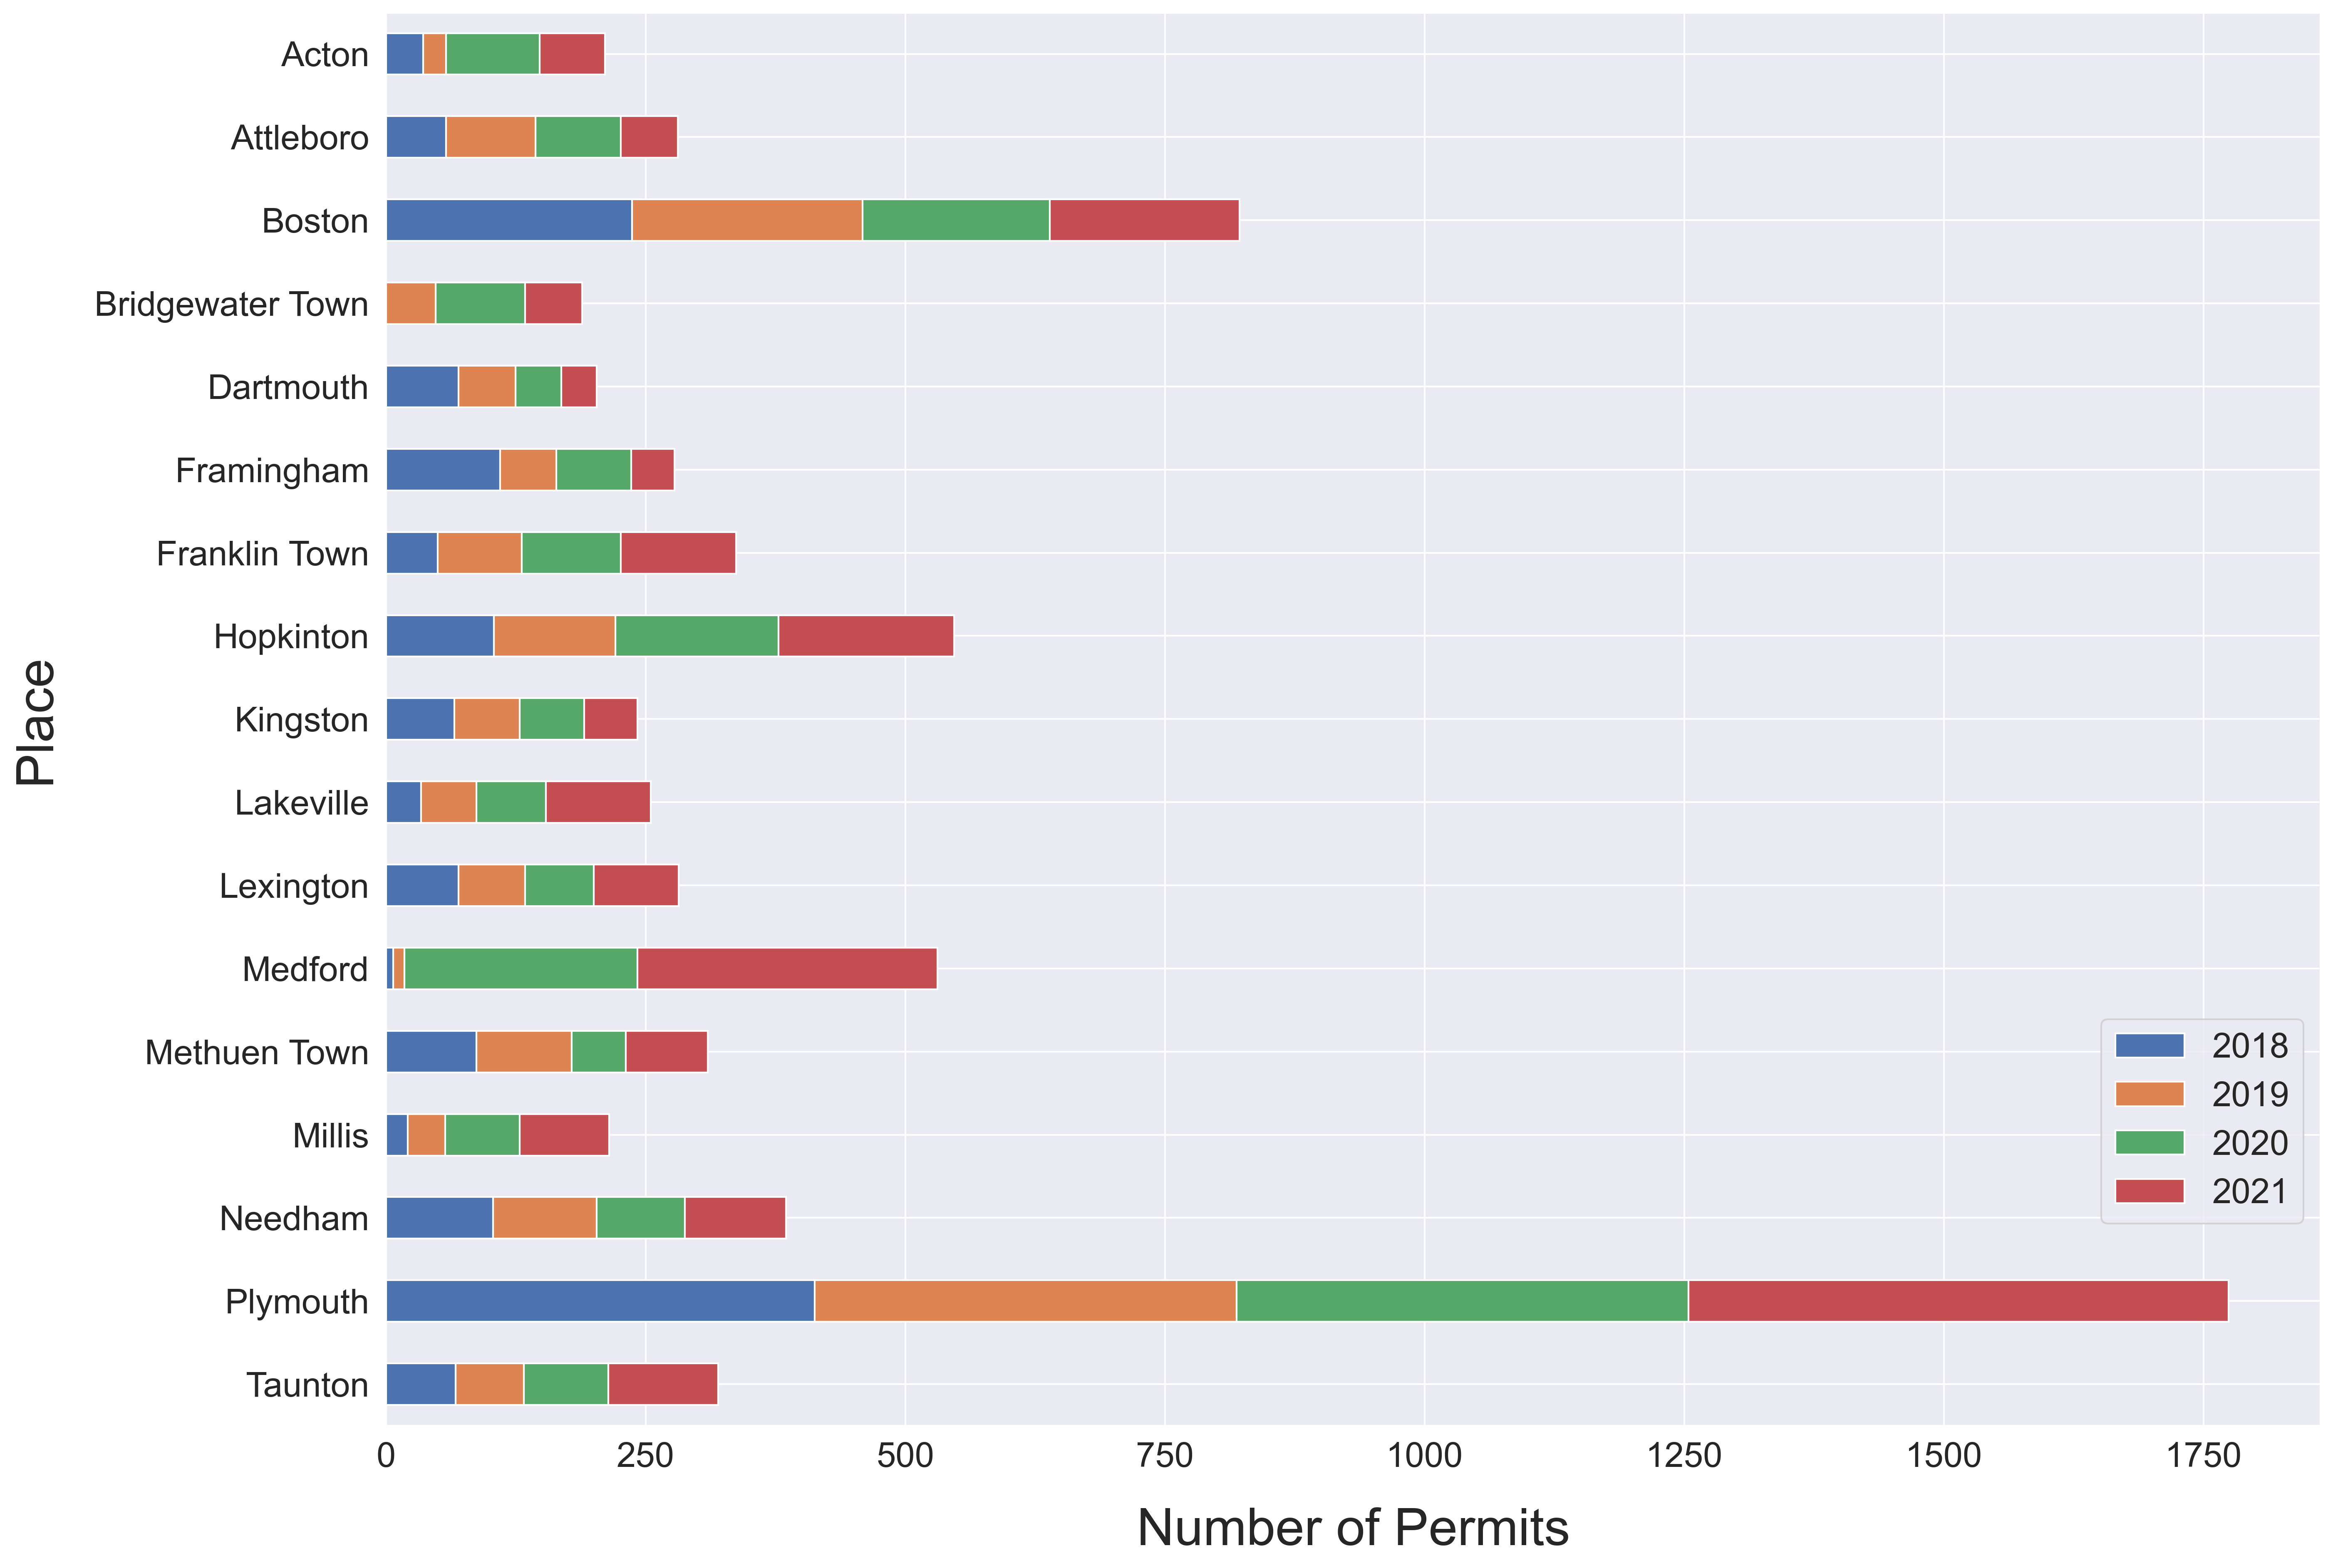

In [51]:
ax = ma_df_topbuild_piv.plot.barh(stacked = True, \
                        figsize = [20,15])

ax.set_xlabel('Number of Permits', fontsize = 30, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('Place', fontsize = 30, labelpad = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20, rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
#ax.set_title('All Residential Building Types Permit Totals', fontsize = 30)
ax.legend(loc = 0, fontsize = 20, bbox_to_anchor=(0.5, 0.0, 0.5, 0.3))

plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\all_res_bar.png', dpi=300, 
            bbox_inches='tight')

In [52]:
top_places = ma_df_topbuild['Place'].unique()

#plotting applications vs time for each of these top places

for i in range(len(top_places)):
    fig, ax = plt.subplots(figsize = (12,4))
    ax.plot('date', 'total_buildings', data = ma_df_topbuild[ma_df_topbuild.Place == top_places[i]], marker = '.')
    plt.axvline(pd.to_datetime('2020-03-01'), color = 'red', linestyle = '--', label = 'MA State of Emergency' )
    plt.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('# of applications')
    ax.set_title(top_places[i])

plt.show()

### Two note worthy initial observations:

- Acton Town appears to have a data entry error showing 75 applications submitted right before the start of 2020. It was confirmed this appeared to be a data entry error by looking at the raw csv files.

- Typically we see a sharp decline in building permit applications when the State of Emergency was declared. However there area  few select places that saw the exact opposite behavior such as Medford, Bridgewater, Millis. It is hypothesized that development plans have long been established in these areas and building permits were trying to get approved ASAP before the building department put a pause on accepting new applications.

- Medford is a good example. Due to the fact that the new green line train extension was passing through Medford, development has been rapidly ramping up since the news was confirmed. As a result, the city has seen the smallest impact of permit submission applications due to COVID-19.

## Break out visualization for single family, small and large multi-unit homes

We have just looked at gross number of permit applications for buildings and indiv. units. Lets perform the analysis for single family homes, small multi-unit homes < 5 units, and large multi-unit homes > 5 units.

In [53]:
#single family home dataframe extraction & processing

top_single_df = ma_df_topbuild[ma_df_topbuild['1-unit_bldgs']>= 1]
top_small_df = ma_df_topbuild[ma_df_topbuild['total_small_bldgs']>= 1]
top_large_df = ma_df_topbuild[ma_df_topbuild['5_plus-units_bldgs']>= 1]

In [54]:
top_singlepiv = top_single_df.pivot_table(index = 'Place', columns = 'year', values = '1-unit_bldgs', aggfunc = np.sum)
top_smallpiv = top_small_df.pivot_table(index = 'Place', columns = 'year', values = 'total_small_bldgs', aggfunc = np.sum)
top_lrgepiv = top_large_df.pivot_table(index = 'Place', columns = 'year', values = '5_plus-units_bldgs', aggfunc = np.sum)

In [55]:
top_singlepiv.pct_change(axis = 'columns')

year              2018      2019      2020      2021
Place                                               
Acton              NaN -0.388889  2.909091 -0.279070
Attleboro          NaN  0.345455  0.094595 -0.358025
Boston             NaN -0.244898 -0.378378  1.304348
Bridgewater Town   NaN       NaN  0.787234 -0.392857
Dartmouth          NaN -0.214286 -0.200000 -0.227273
Framingham         NaN -0.343284  0.454545 -0.375000
Franklin Town      NaN  0.480000  0.135135  0.166667
Hopkinton          NaN  0.125000  0.341880  0.076433
Kingston           NaN -0.045455 -0.015873 -0.177419
Lakeville          NaN  0.558824  0.226415  0.553846
Lexington          NaN -0.085714  0.031250  0.242424
Medford            NaN  1.500000  0.200000  0.166667
Methuen Town       NaN  0.057471 -0.445652  0.490196
Millis             NaN  0.523810  0.906250  0.245902
Needham            NaN -0.050000 -0.157895  0.162500
Plymouth           NaN -0.016949  0.071429  0.195402
Taunton            NaN -0.068966  0.351852  0.150685

In [56]:
top_smallpiv.pct_change(axis = 'columns')

year              2018      2019      2020      2021
Place                                               
Acton              NaN       NaN       NaN  0.000000
Attleboro          NaN  3.000000 -0.916667  2.000000
Boston             NaN -0.086538 -0.136842 -0.231707
Bridgewater Town   NaN       NaN  0.000000  2.000000
Framingham         NaN -0.823529  0.333333 -0.750000
Lakeville          NaN       NaN       NaN  0.000000
Medford            NaN -0.600000  1.000000 -0.750000
Methuen Town       NaN       NaN       NaN  0.000000
Millis             NaN       NaN  1.750000 -0.090909
Needham            NaN  1.500000  0.000000 -0.200000
Taunton            NaN  0.333333 -0.333333  1.750000

In [57]:
top_lrgepiv.pct_change(axis = 'columns')

year              2018      2019       2020      2021
Place                                                
Acton              NaN       NaN        NaN       NaN
Boston             NaN  0.071429  -0.166667 -0.106667
Bridgewater Town   NaN       NaN        NaN  0.000000
Framingham         NaN -0.555556   0.000000  0.000000
Franklin Town      NaN       NaN   0.571429  0.181818
Lakeville          NaN       NaN        NaN  0.000000
Medford            NaN       NaN  52.500000  0.313084
Methuen Town       NaN       NaN        NaN       NaN
Needham            NaN  0.000000   0.000000  0.000000

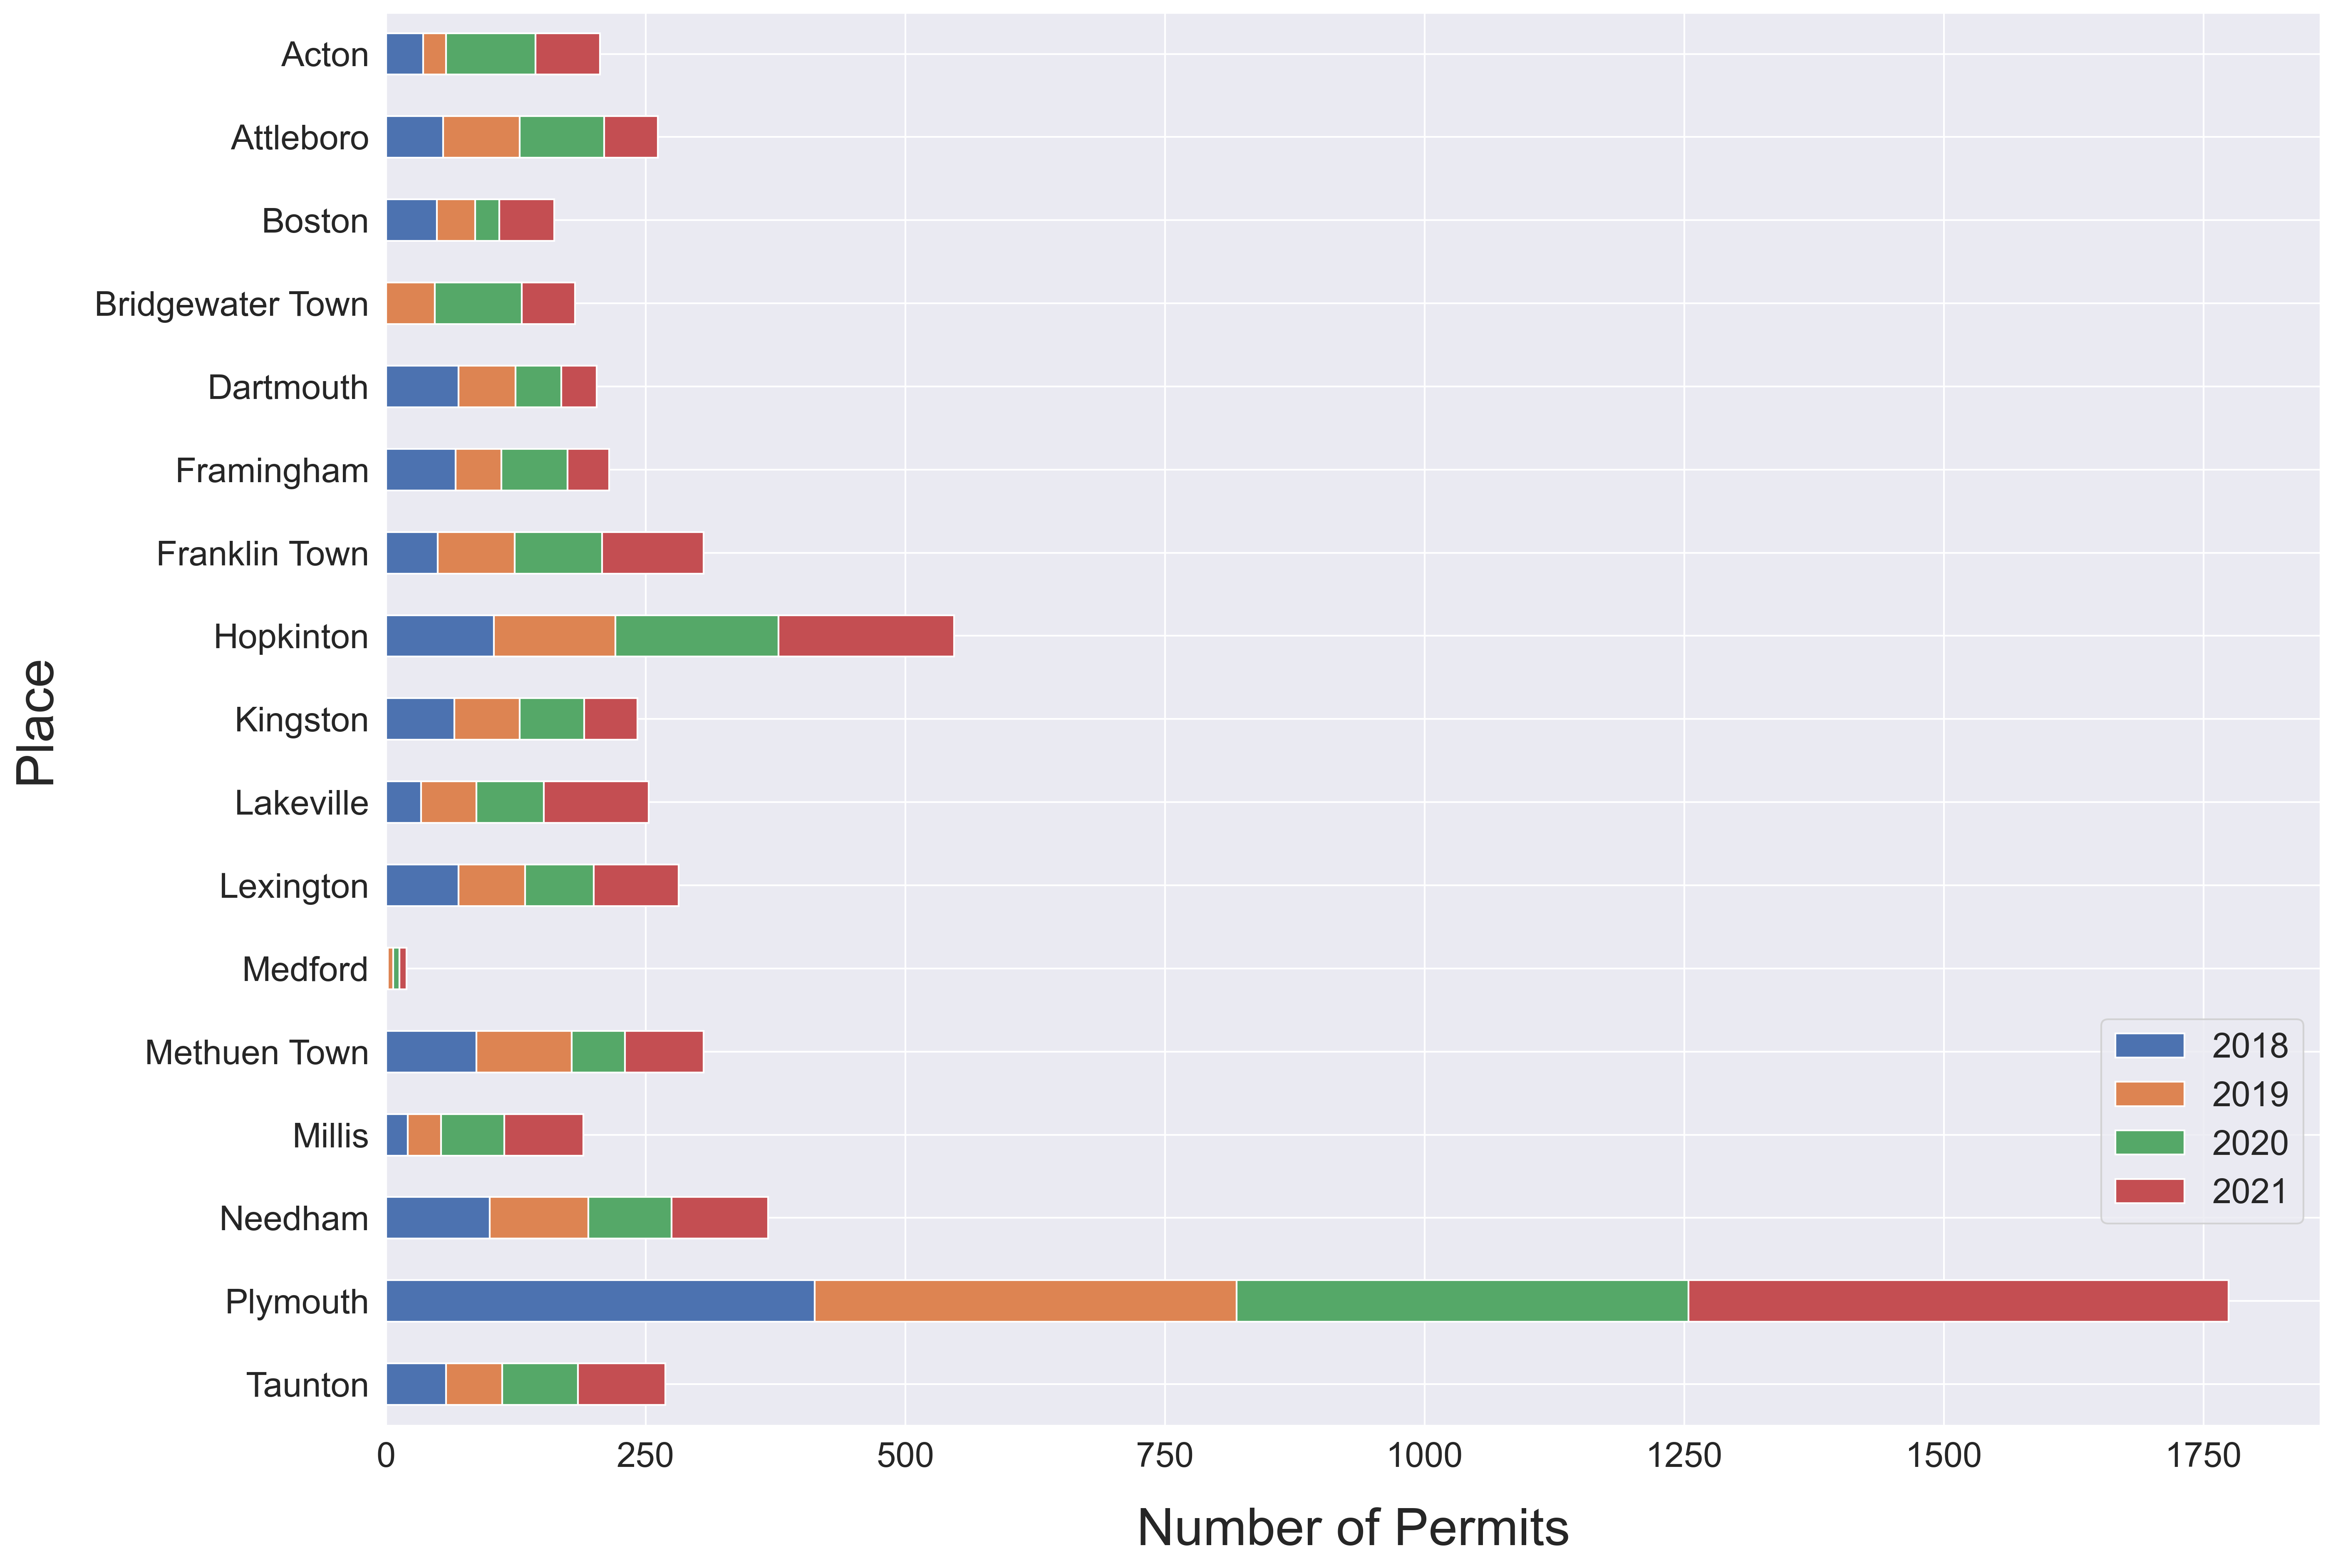

In [58]:
ax = top_singlepiv.plot.barh(stacked = True, \
                        figsize = [20,15])
ax.set_xlabel('Number of Permits', fontsize = 30, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('Place', fontsize = 30, labelpad = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20, rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
#ax.set_title('Single Family Residential Building Permit Totals', fontsize = 30)
ax.legend(loc = 0, fontsize = 20, bbox_to_anchor=(0.5, 0.0, 0.5, 0.3))

plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\single_res_bar.png', dpi=300,
           bbox_inches='tight')

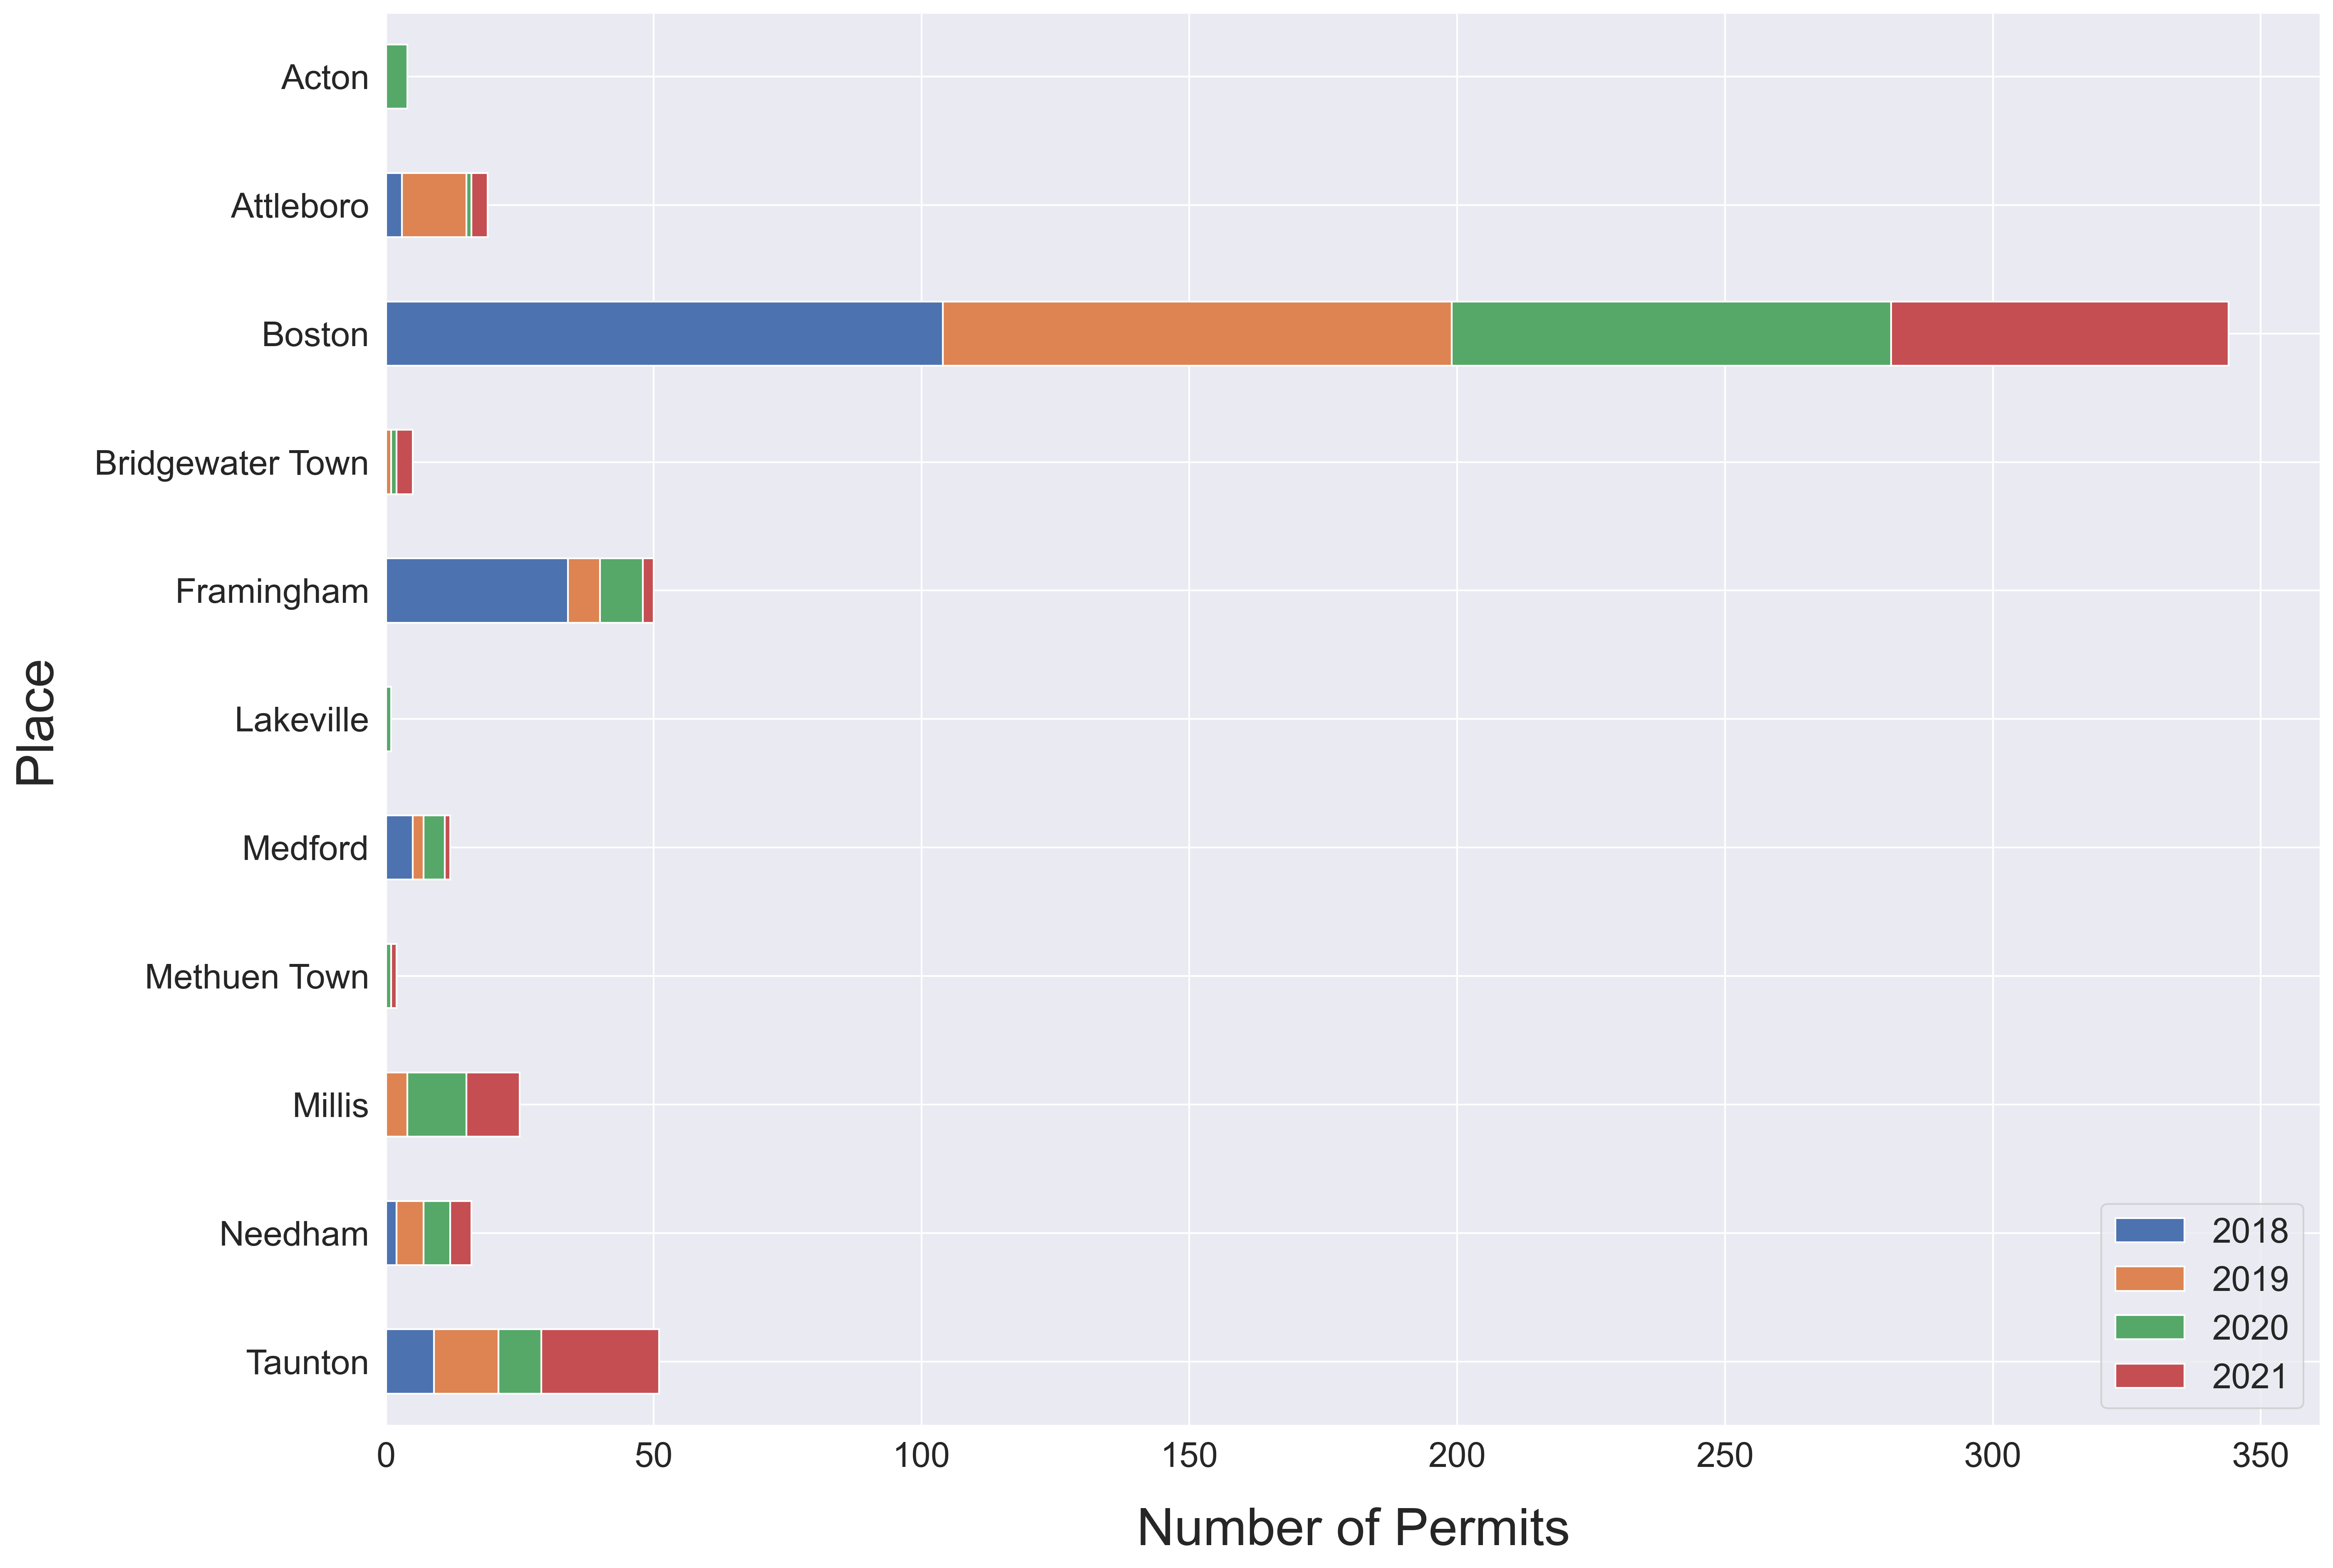

In [59]:
ax = top_smallpiv.plot.barh(stacked = True, \
                        figsize = [20,15])

ax.set_xlabel('Number of Permits', fontsize = 30, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('Place', fontsize = 30, labelpad = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20, rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
#ax.set_title('Small Multi-Unit Residential Building Permit Totals', fontsize = 30)
ax.legend(loc = 4, fontsize = 20)
plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\small_res_bar.png', dpi=300,
           bbox_inches='tight')

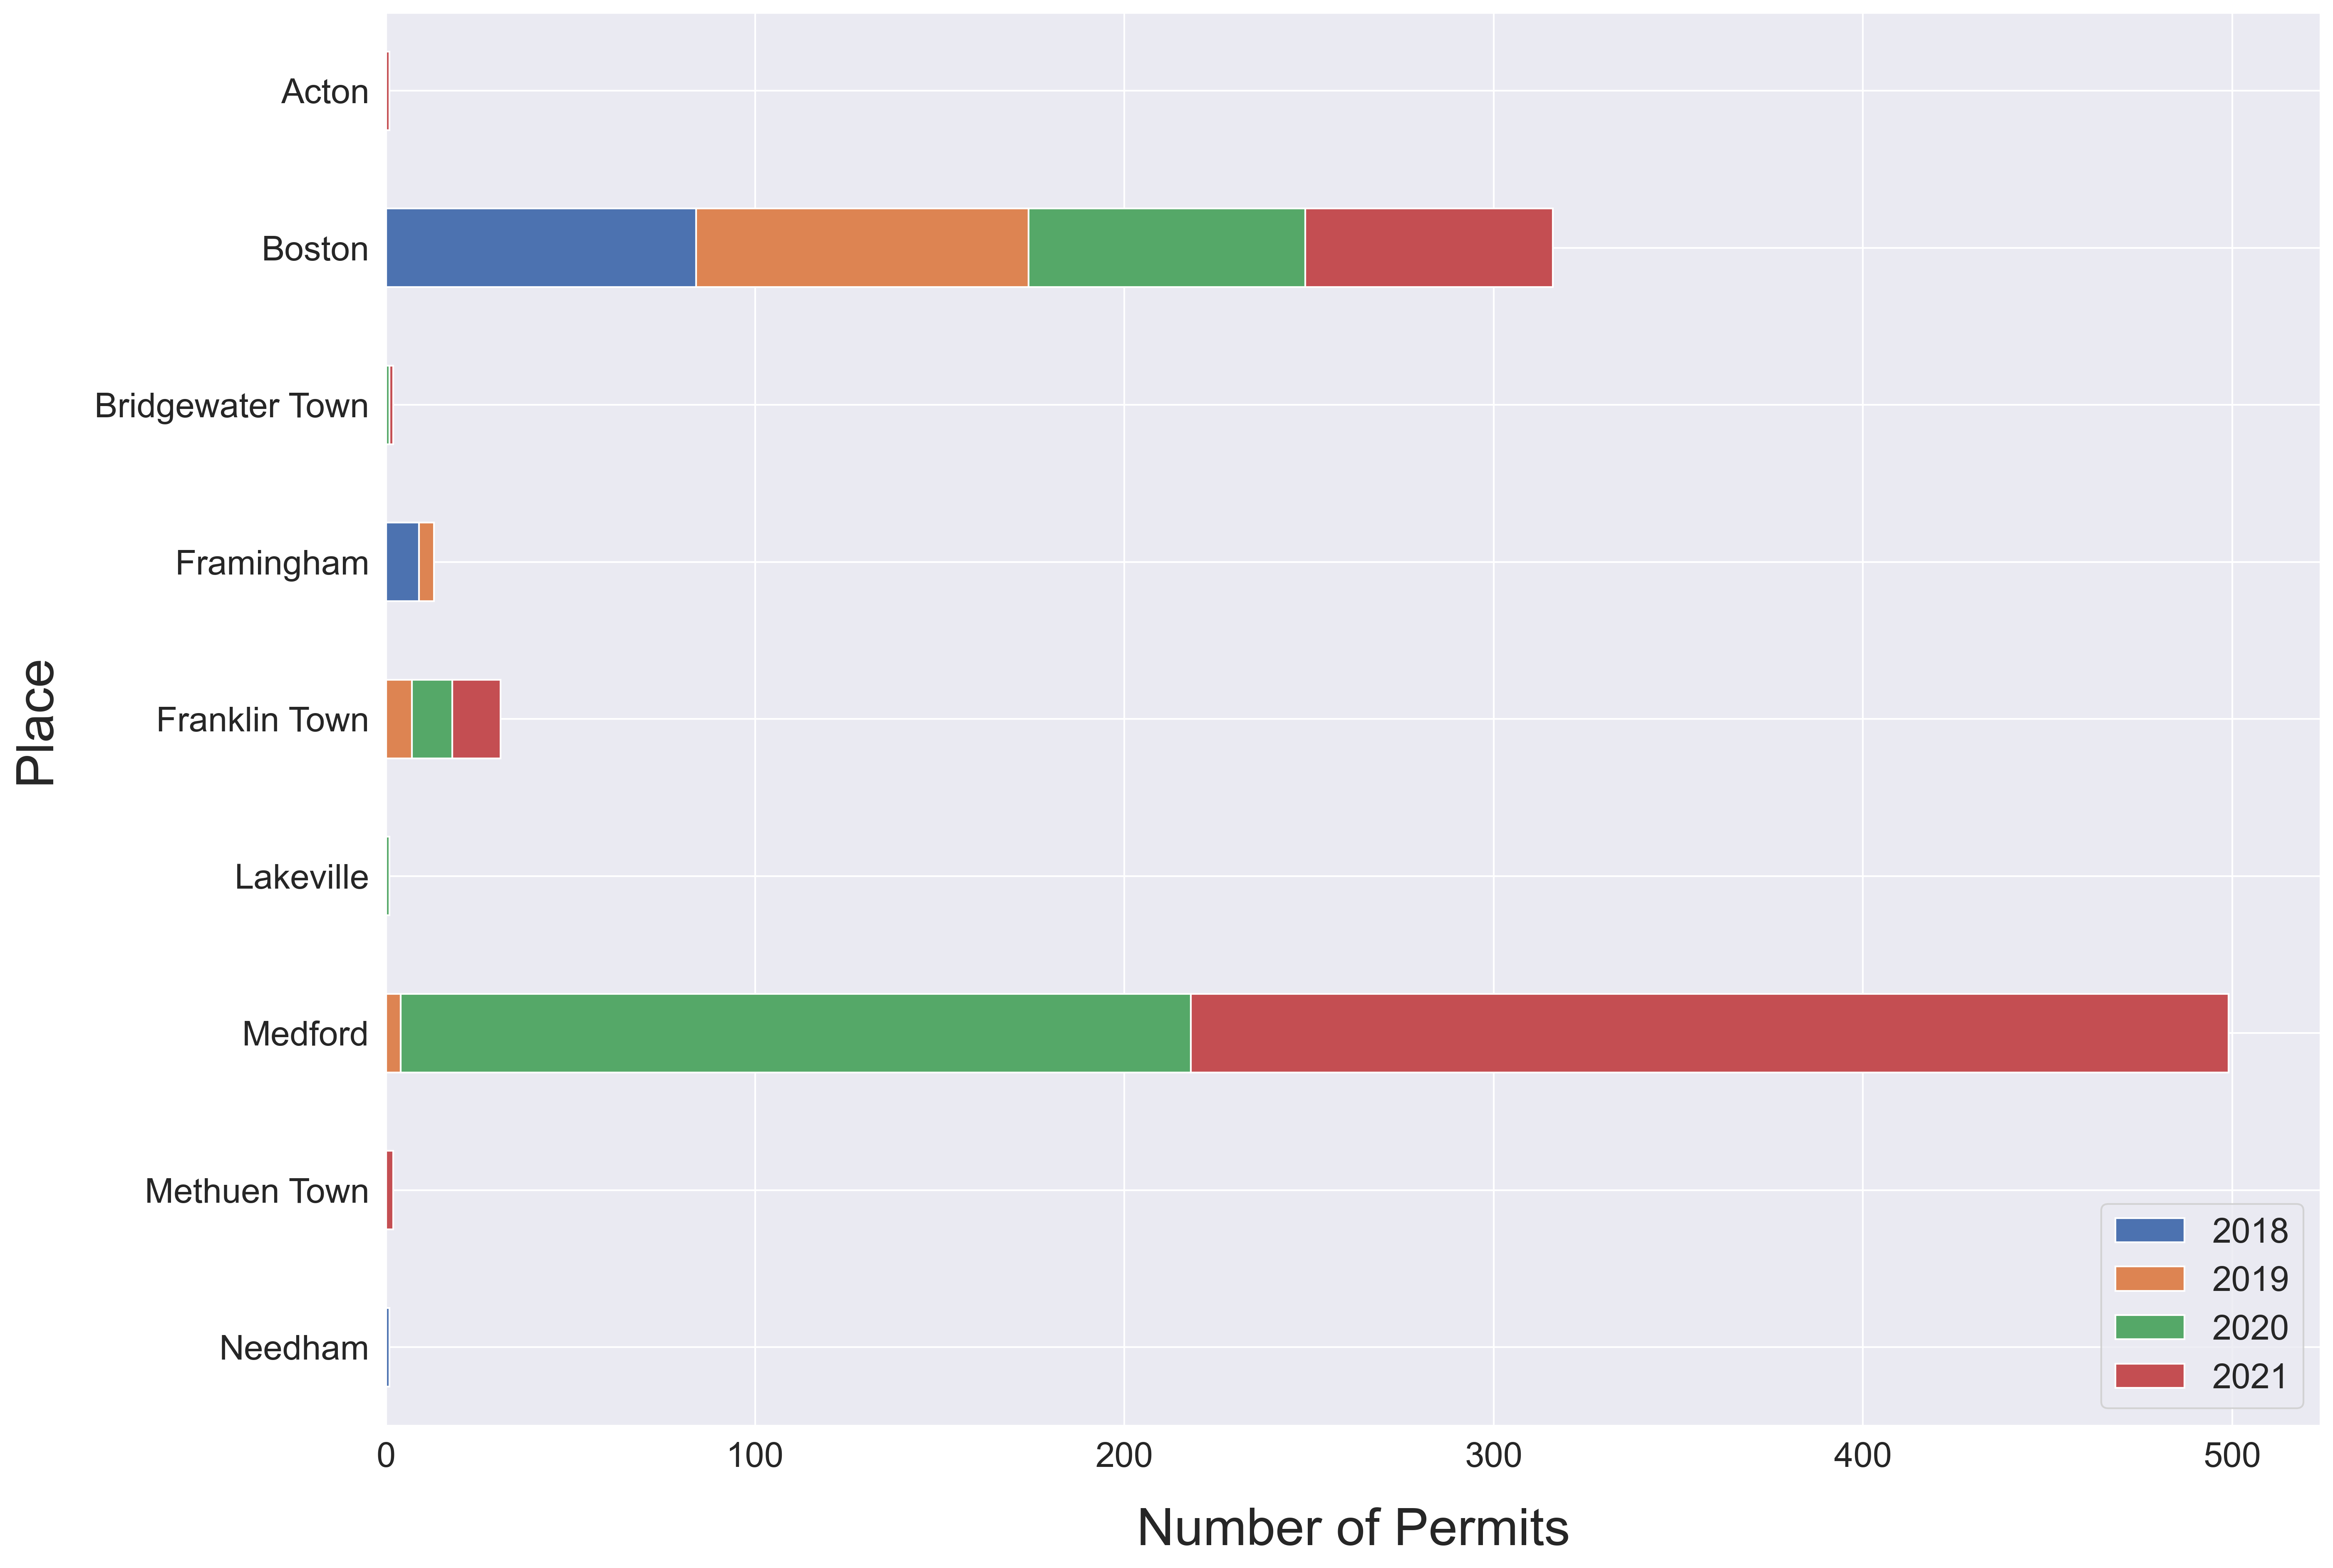

In [60]:
ax = top_lrgepiv.plot.barh(stacked = True, \
                        figsize = [20,15])

ax.set_xlabel('Number of Permits', fontsize = 30, labelpad = 20 )
    #labelpad provides more space between xlabel and xticks
ax.set_ylabel('Place', fontsize = 30, labelpad = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20, rotation = 0)
ax.invert_yaxis() #plots bar graph in descending order
#ax.set_title('Large Multi-Unit Residential Building Permit Totals', fontsize = 30)
ax.legend(loc = 4, fontsize = 20)

plt.savefig(r'C:\Users\sjauy\Python\HODP\building_permit_analysis\permit_env\Figures\large_res_bar.png', dpi=300,
           bbox_inches='tight')

# 5. Hypothesis Testing

Did places within urban areas see a statistical difference in building permit submissions vs towns in urban places before and after the MA State of Emergency (SOE) implementation? Null hypothesis is that there is no difference. Perform a chi2 test to determine statistical significance.

In [61]:
ma_df['covid_ref'] = ma_df['date'].apply(lambda val: 'post_lockdown' if val >= pd.to_datetime('2020-03-10')\
                                         else ('pre_lockdown'))

In [62]:
ma_df.head()

date  State  6-Digit  County FIPS Place FIPS MCD      Pop  CSA   CBSA  \
0 2010-01-01     25     1000      23        NaN   00170   14605.0  148  14460   
1 2010-01-01     25     3000      17        NaN   00380   20331.0  148  14460   
2 2010-01-01     25     9000      13     00765    00765   28144.0  999  44140   
3 2010-01-01     25    13000       9        NaN   01185   16450.0  148  14460   
4 2010-01-01     25    17000       9        NaN   01465   31247.0  148  14460   

           Zip     Place  1-unit_bldgs  1-unit_units  1-unit_value  \
0  02351        Abington             1             1        231556   
1  01720           Acton             0             0             0   
2  01001          Agawam             3             3        544000   
3  01913        Amesbury             0             0             0   
4  01810         Andover             2             2       1737781   

   2-units_bldgs  2-unit_units  2-unit_value  3-4-units_bldgs  3-4-unit_units  \
0              0             0             0                0               0   
1              0             0             0                0               0   
2              1             2        148000                0               0   
3              0             0             0                0               0   
4              0             0             0                0               0   

   3-4-unit_value  5_plus-units_bldgs  5_plus-units_units  5_plus-units_value  \
0               0                   0                   0                   0   
1               0                   0                   0                   0   
2               0                   0                   0                   0   
3               0                   0                   0                   0   
4               0                   0                   0                   0   

       classif  year  month  total_buildings  total_small_bldgs  total_units  \
0  Urban_Place  2010      1                1                  0            1   
1  Urban_Place  2010      1                0                  0            0   
2  Urban_Place  2010      1                4                  1            5   
3  Urban_Place  2010      1                0                  0            0   
4  Urban_Place  2010      1                2                  0            2   

   total_small_units       county_name     covid_ref  
0                  0   Plymouth County  pre_lockdown  
1                  0  Middlesex County  pre_lockdown  
2                  2    Hampden County  pre_lockdown  
3                  0      Essex County  pre_lockdown  
4                  0      Essex County  pre_lockdown

In [63]:
SOE_df = ma_df.query('classif != "Rural" & date > "2018-01-01"')
SOE_df['covid_ref'].value_counts()

pre_lockdown     4706
post_lockdown    4647
Name: covid_ref, dtype: int64

In [64]:
SOE_table = pd.pivot_table(SOE_df, index = ['classif', 'covid_ref'], values = ['total_buildings'], aggfunc = np.sum)

In [65]:
SOE_table

total_buildings
classif     covid_ref                     
Urban_Area  post_lockdown             3407
            pre_lockdown              2903
Urban_Place post_lockdown             8613
            pre_lockdown              8471

In [66]:
ua_up_contingency = [[2903, 3407],
                    [8471, 8613]]

chi2, pval, dof, expected = chi2_contingency(ua_up_contingency)

In [67]:
print(pval)

1.2669304886542027e-06


## Findings

Using the standard p-value statistical significance threshold = 0.05, we see that our p-value is much smaller than the specified threshold. This indicates there is a significant statistical difference between the building permit submission rate pre and post Massachusetts state of emergency implementation.